# Importing the Libraries

In [317]:
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import Ridge, LogisticRegression, LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score, recall_score, precision_score, f1_score
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE, mutual_info_classif as MIC

### Importing the dataset

In [318]:
dataset = pd.read_csv('bank-additional-full.csv', sep=';', quotechar='"')

In [319]:
print(f"Samples:\t{dataset.shape[0]}\nFeatures:\t{dataset.shape[1]}")

Samples:	41188
Features:	21


### Reordering the columns order as numerical to categorical

In [320]:
dataset_copy = dataset.copy()
# Separate numerical and categorical columns
numerical_columns = dataset_copy.select_dtypes(include='number').columns.tolist()
categorical_columns = dataset_copy.select_dtypes(exclude='number').columns.tolist()

# Reorder the dataset as starting with numerical columns then categorical
new_order = numerical_columns + categorical_columns
dataset_copy = dataset_copy[new_order]

In [321]:
dataset_copy.dtypes

age                 int64
duration            int64
campaign            int64
pdays               int64
previous            int64
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
poutcome           object
y                  object
dtype: object

# -----------------------------------------------------------------------------------------------------------------

## Handling missing values

In [322]:
# Only categorical features has missing values
categorical_columns = dataset_copy.select_dtypes(exclude='number').columns.tolist()

# Replacing the "unknown" with np.nan
dataset_miss    = dataset_copy.replace('unknown', np.nan).copy()
dataset_no_miss = dataset_miss.fillna(dataset_miss.mode().iloc[0]).copy()

#Check missing values whether correctly removed or not
print(dataset_no_miss[categorical_columns].isna().sum())

job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
poutcome       0
y              0
dtype: int64


### Feature Encoding

In [323]:
dataset_no_encoded = dataset_no_miss.copy()
dataset_encoded    = dataset_no_miss.copy()

In [324]:
label_encoder = LabelEncoder()

for column in categorical_columns:
    dataset_encoded[column] = label_encoder.fit_transform(dataset_no_encoded[column])

#Check dtypes whether correctly encoded or not
dataset_encoded.dtypes

age                 int64
duration            int64
campaign            int64
pdays               int64
previous            int64
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
job                 int32
marital             int32
education           int32
default             int32
housing             int32
loan                int32
contact             int32
month               int32
day_of_week         int32
poutcome            int32
y                   int32
dtype: object

## Handling outliers

In [325]:
dataset_with_outliers = dataset_encoded.copy()

In [326]:
from scipy.stats import zscore  # Z-score shows better performance than IQR for this particular dataset

z_scores = np.abs(zscore(dataset_with_outliers))
threshold = 3   # threshold=3 gives the suitable option if threshold > 3 then we lost data over %40 
dataset_no_outliers = dataset_with_outliers[(z_scores < threshold).all(axis=1)]

In [327]:
print(f"Samples with outliers:   \t{dataset_with_outliers.shape[0]}, Columns:\t{dataset_with_outliers.shape[1]}")
print(f"Samples without outliers:\t{dataset_no_outliers.shape[0]}, Columns:\t{dataset_no_outliers.shape[1]}")
print(f"Sample Loss: \t\t\t\t%{((dataset_with_outliers.shape[0] - dataset_no_outliers.shape[0])/dataset_with_outliers.shape[0]) * 100:.4f}")

Samples with outliers:   	41188, Columns:	21
Samples without outliers:	37311, Columns:	21
Sample Loss: 				%9.4129


## Data Visualization

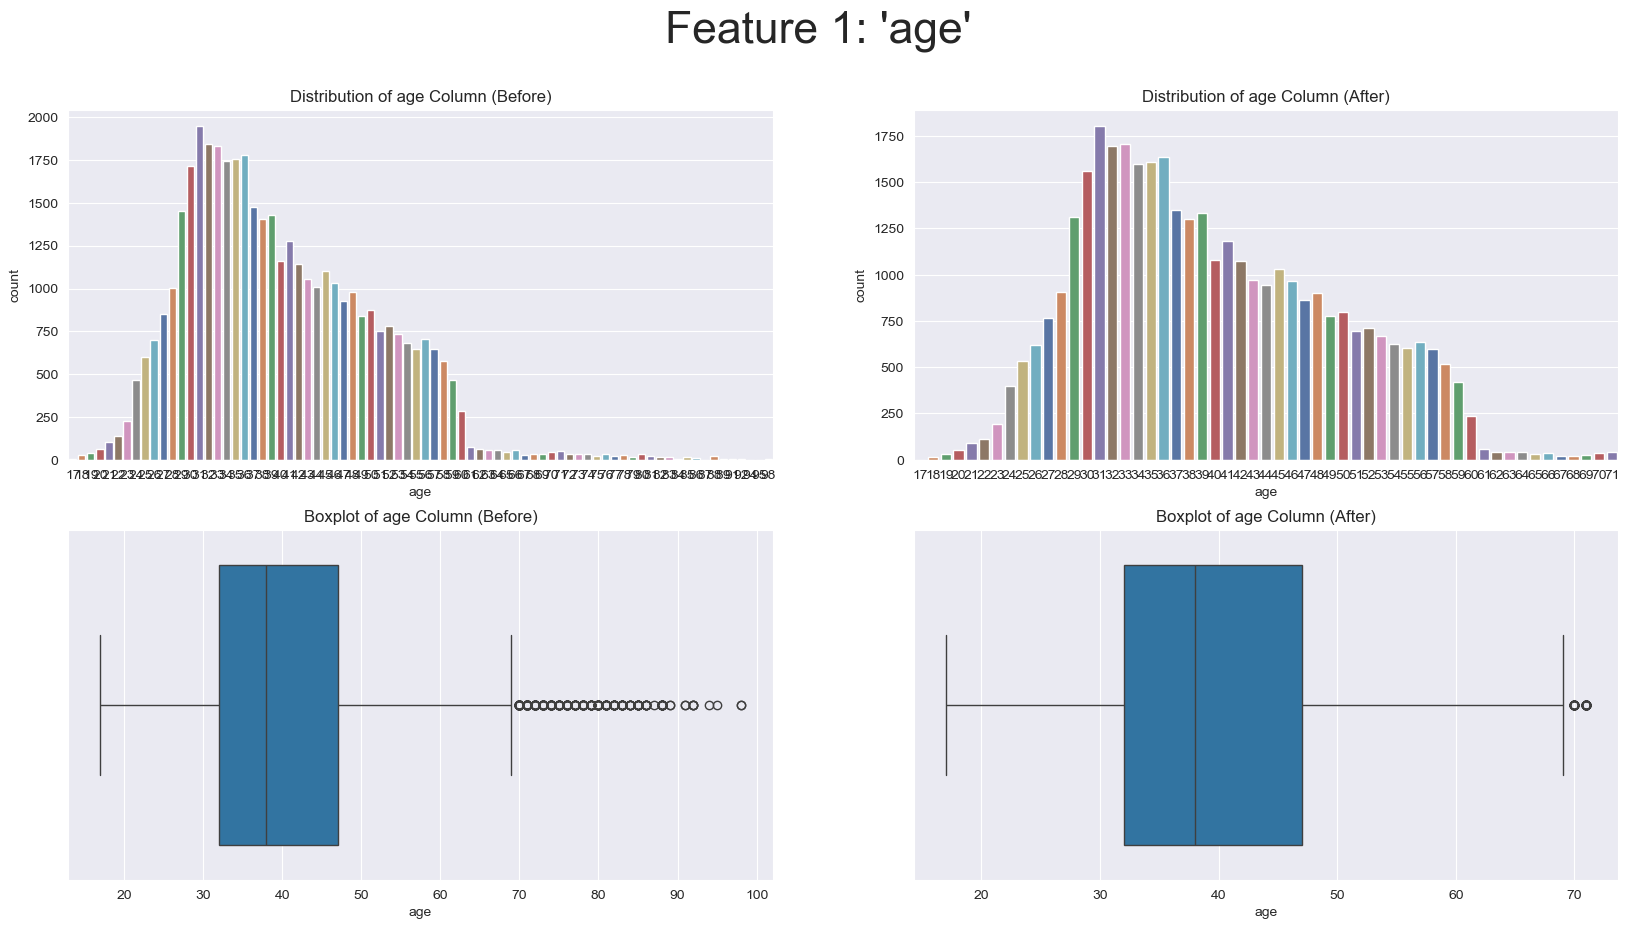

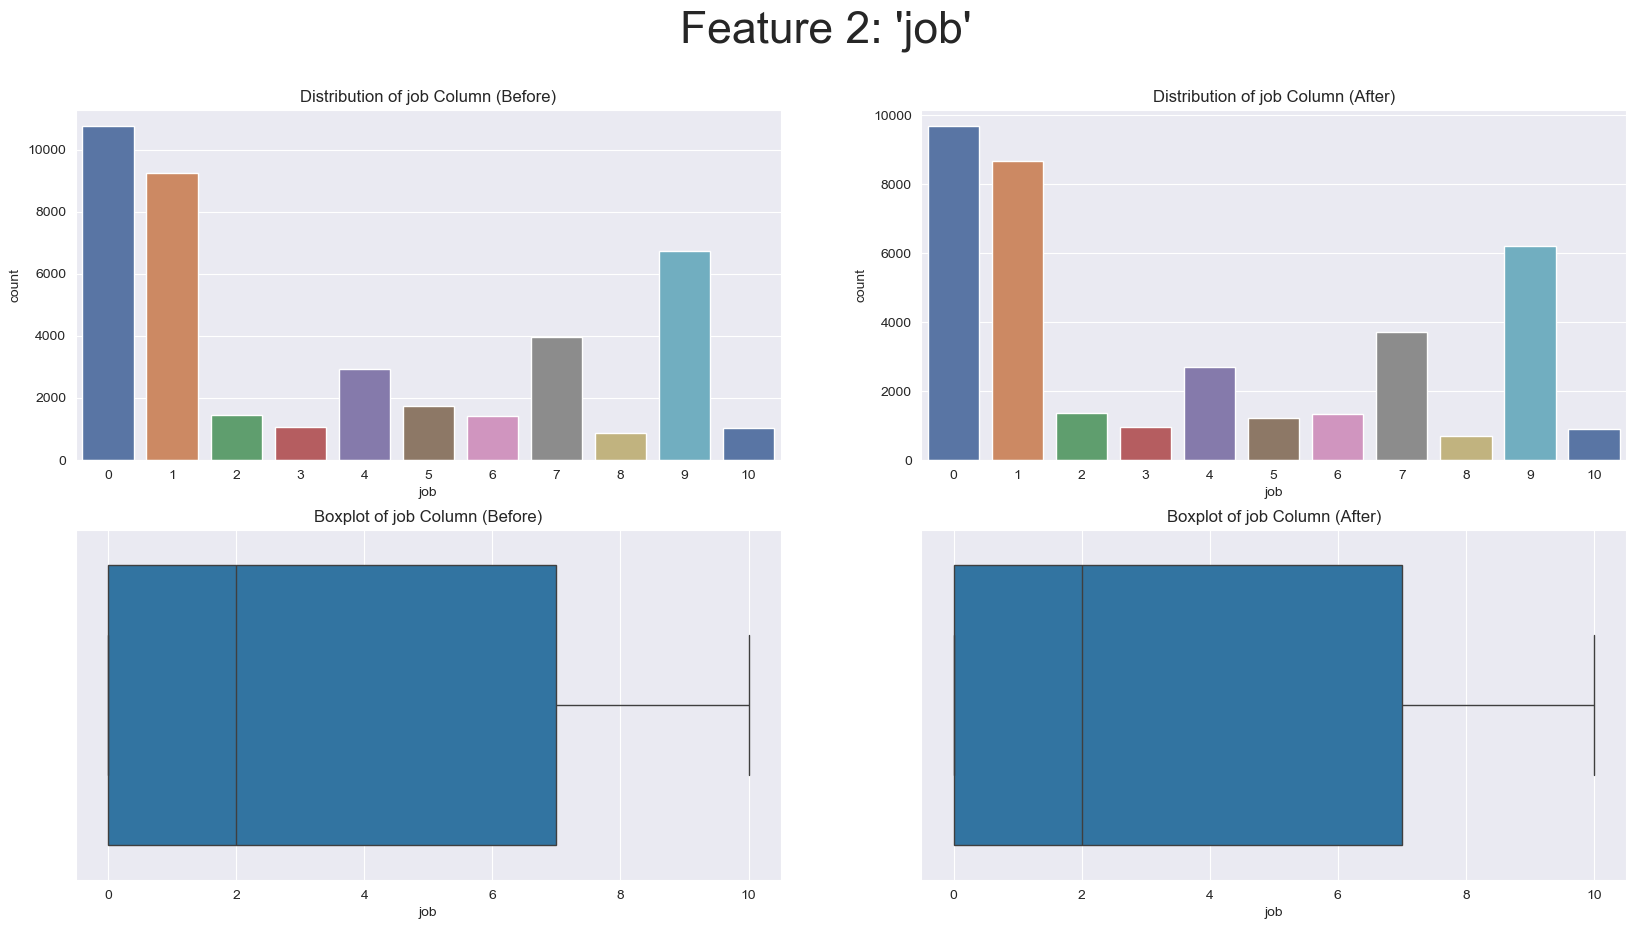

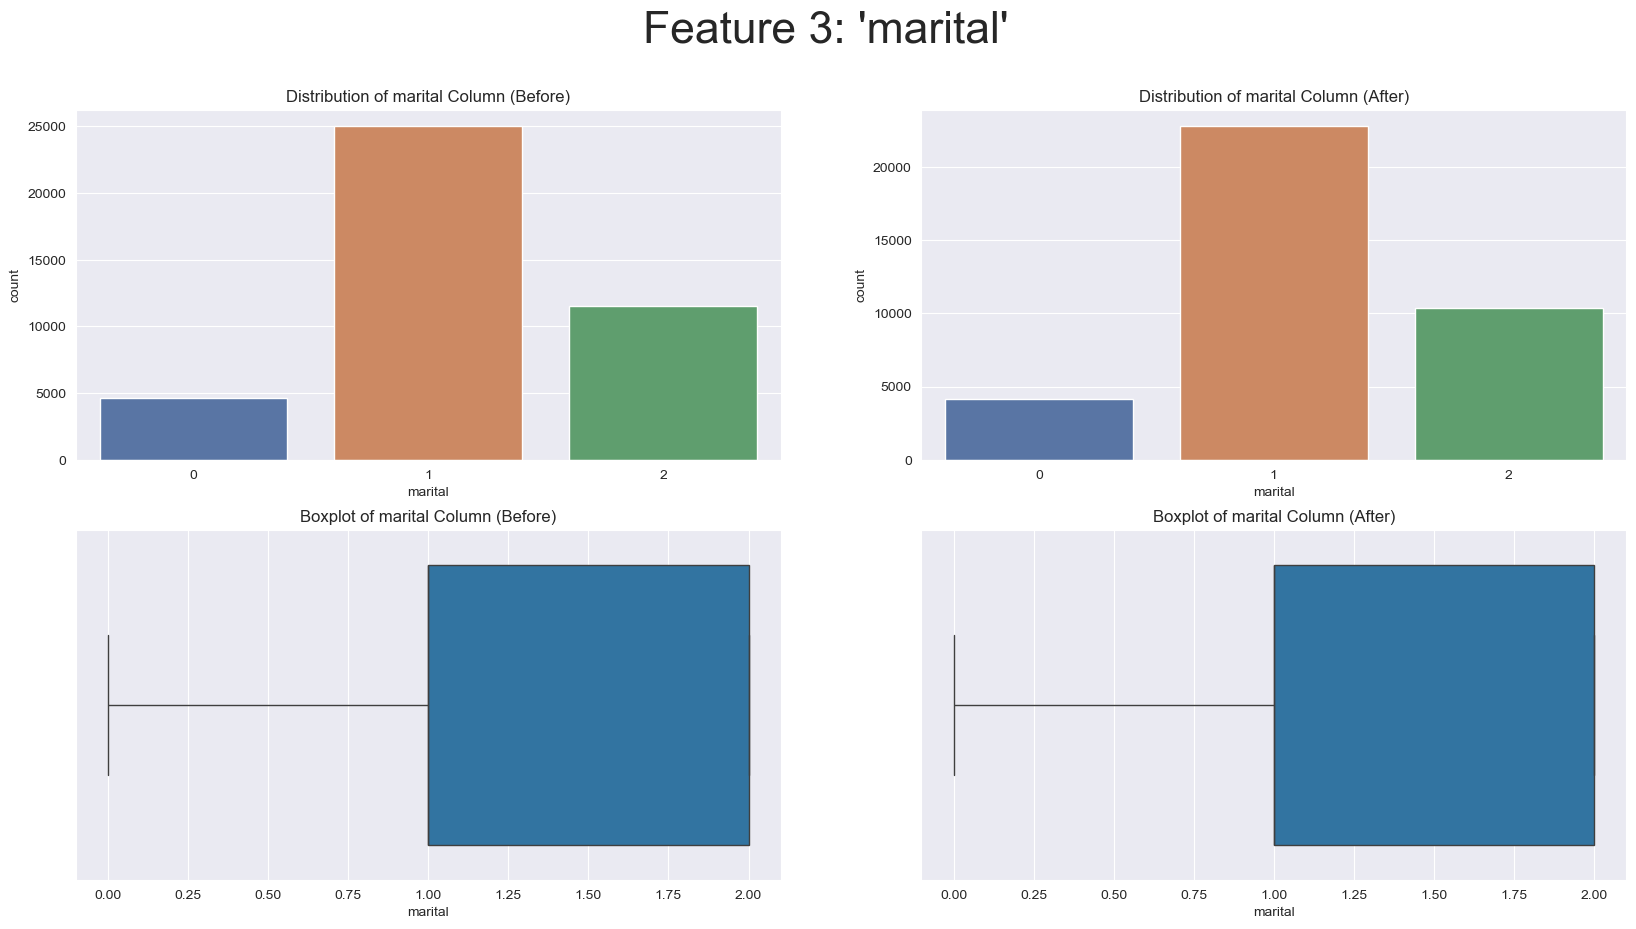

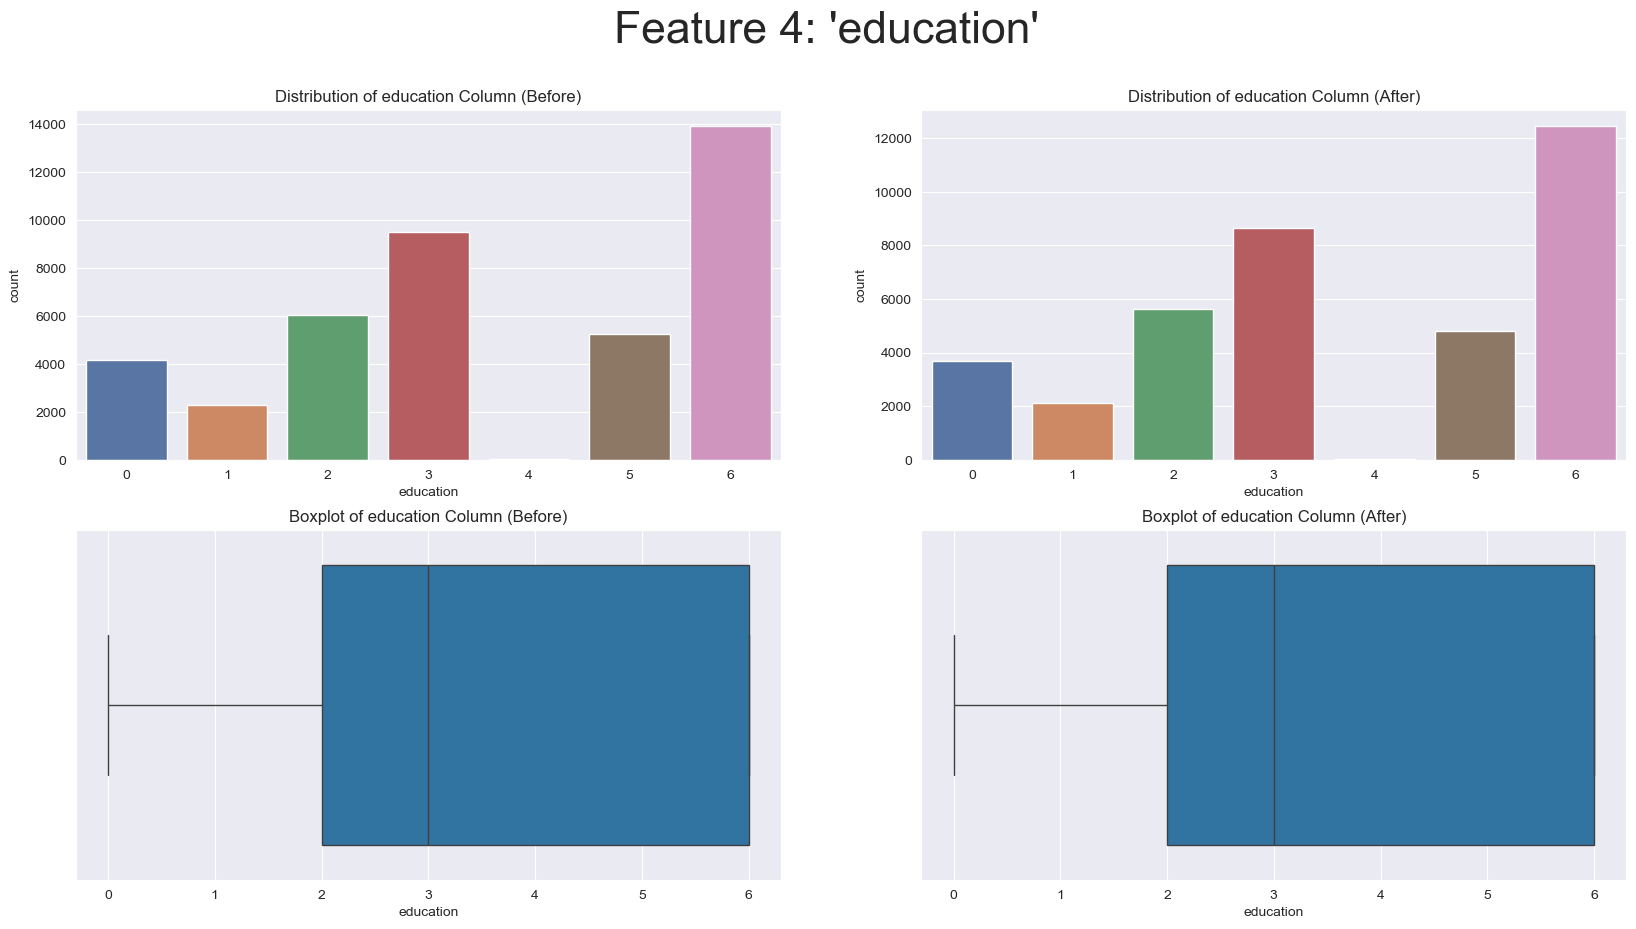

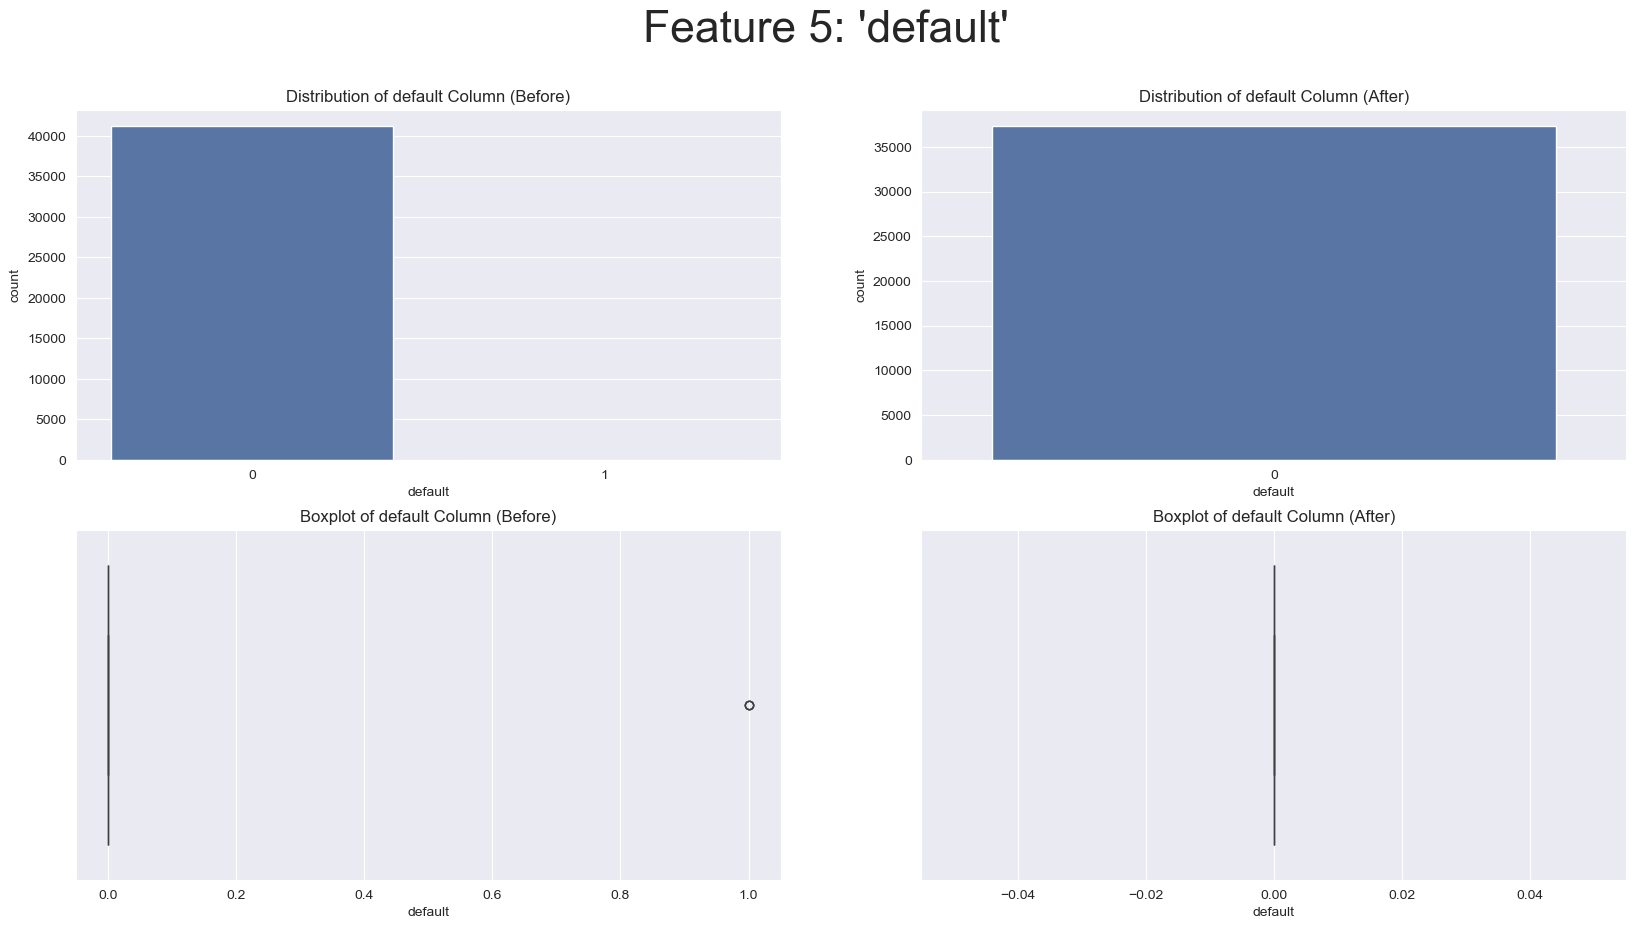

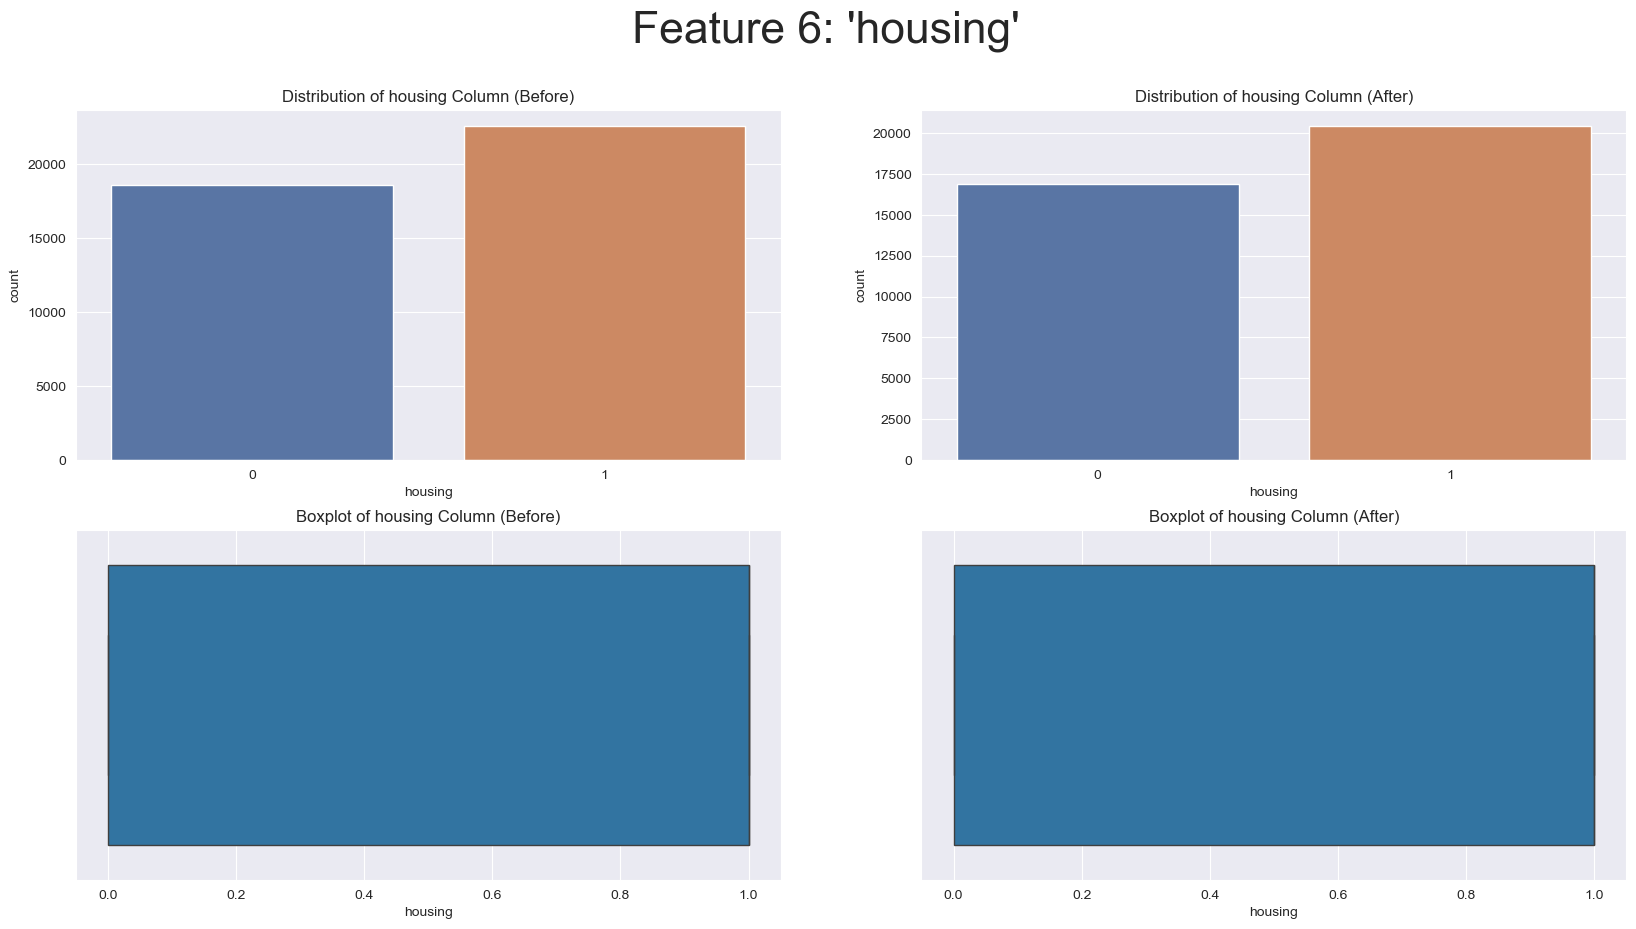

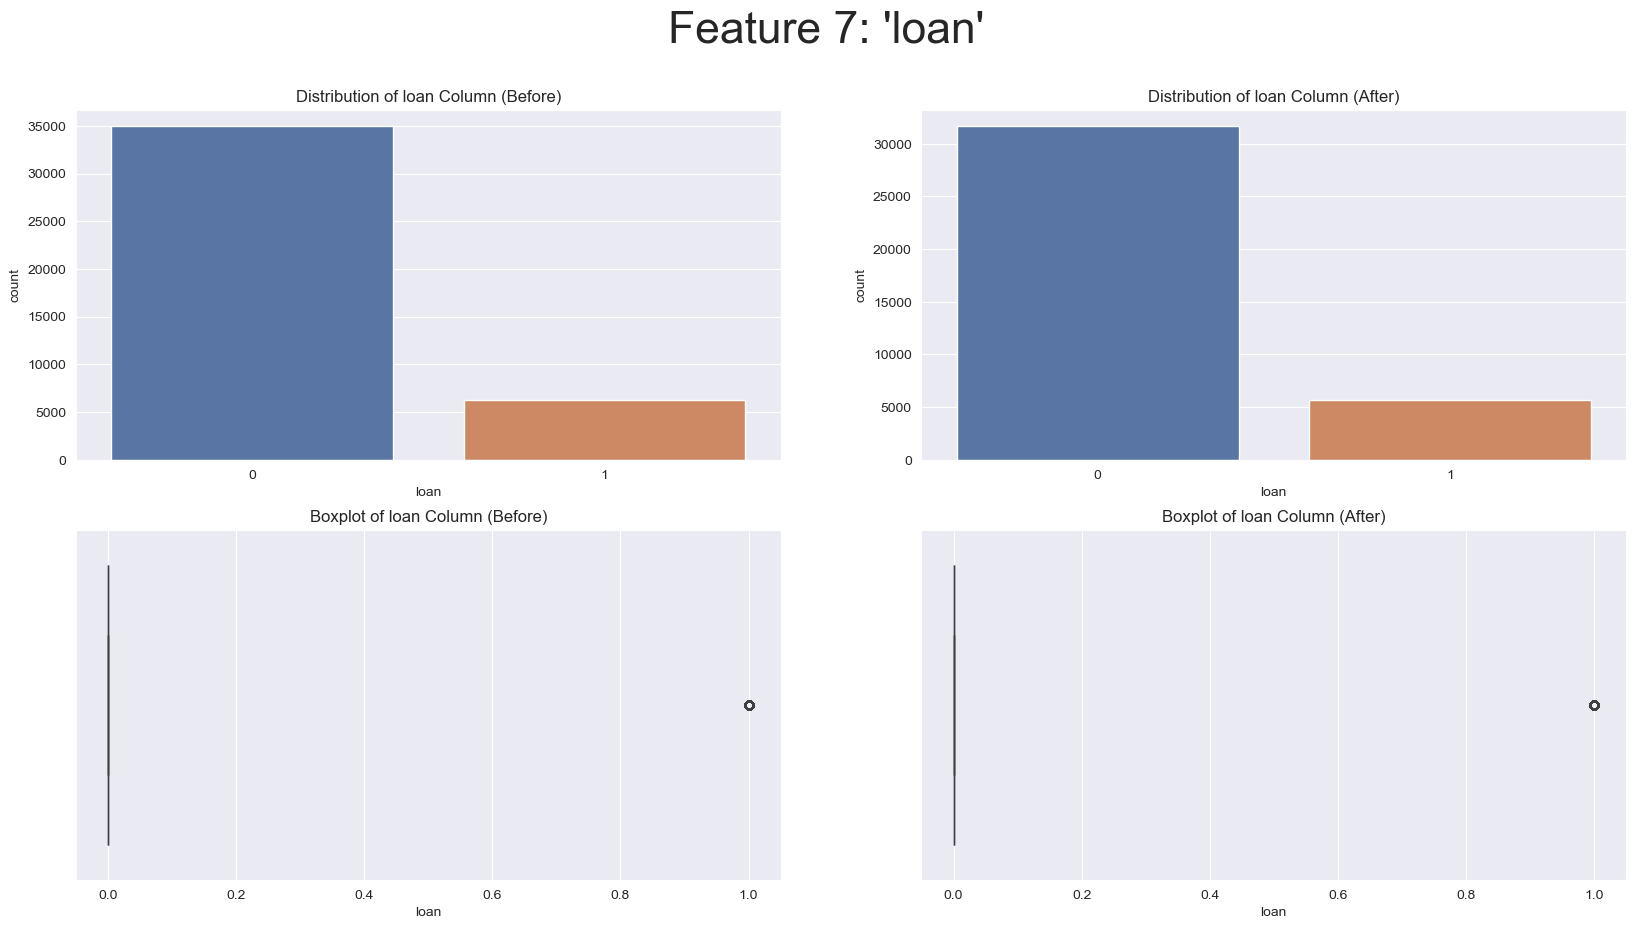

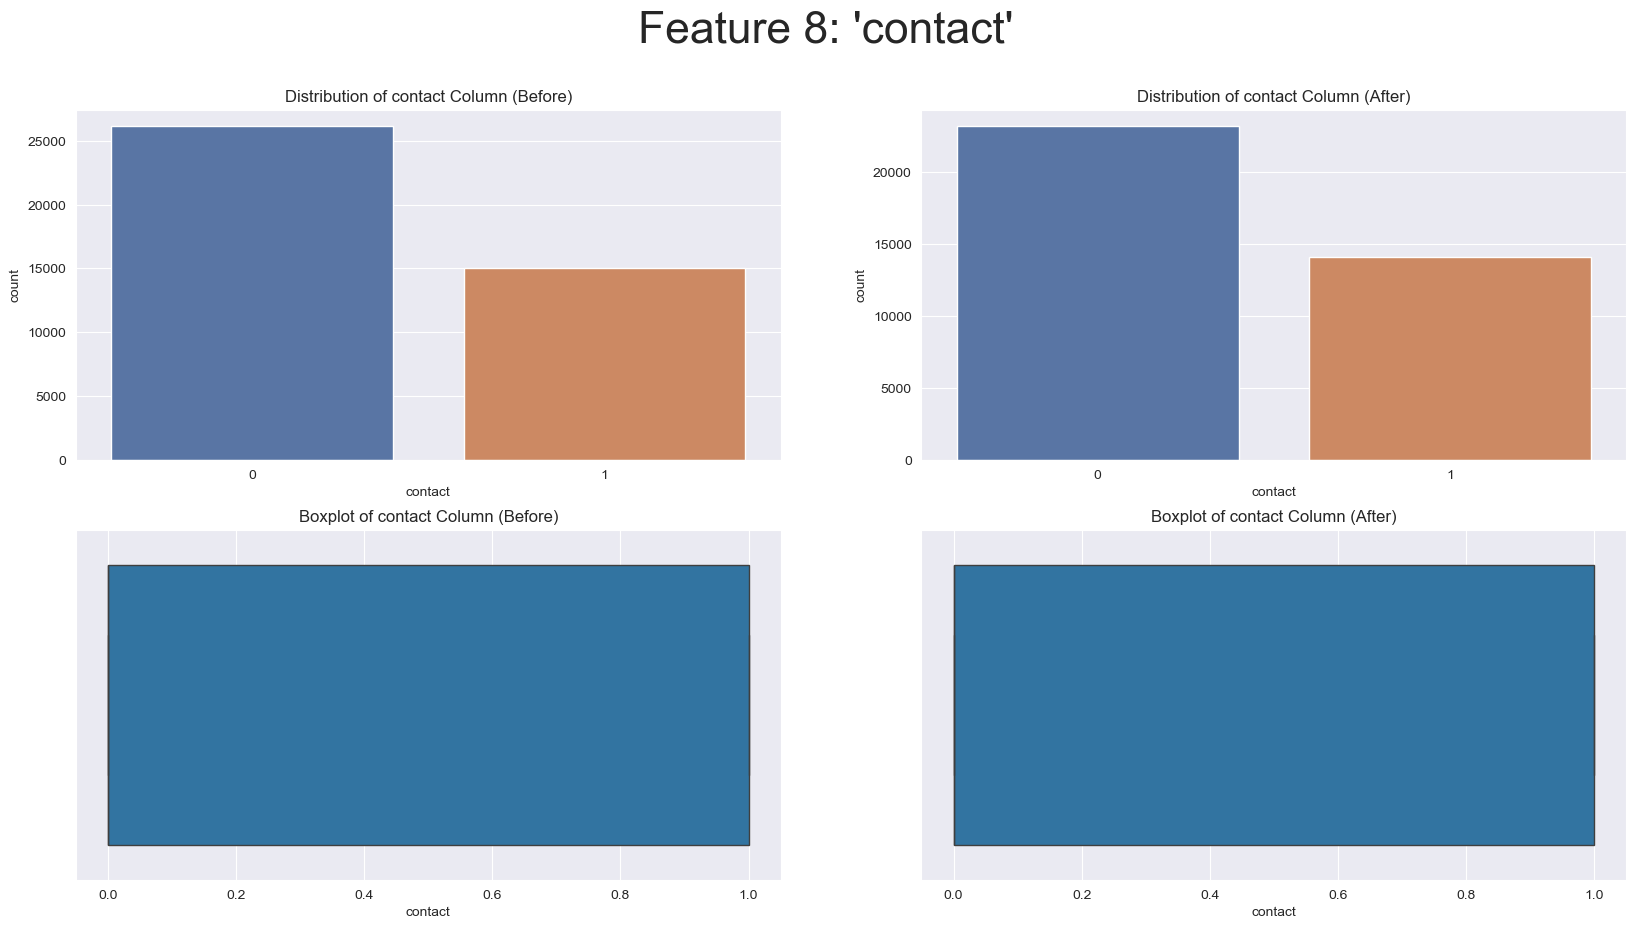

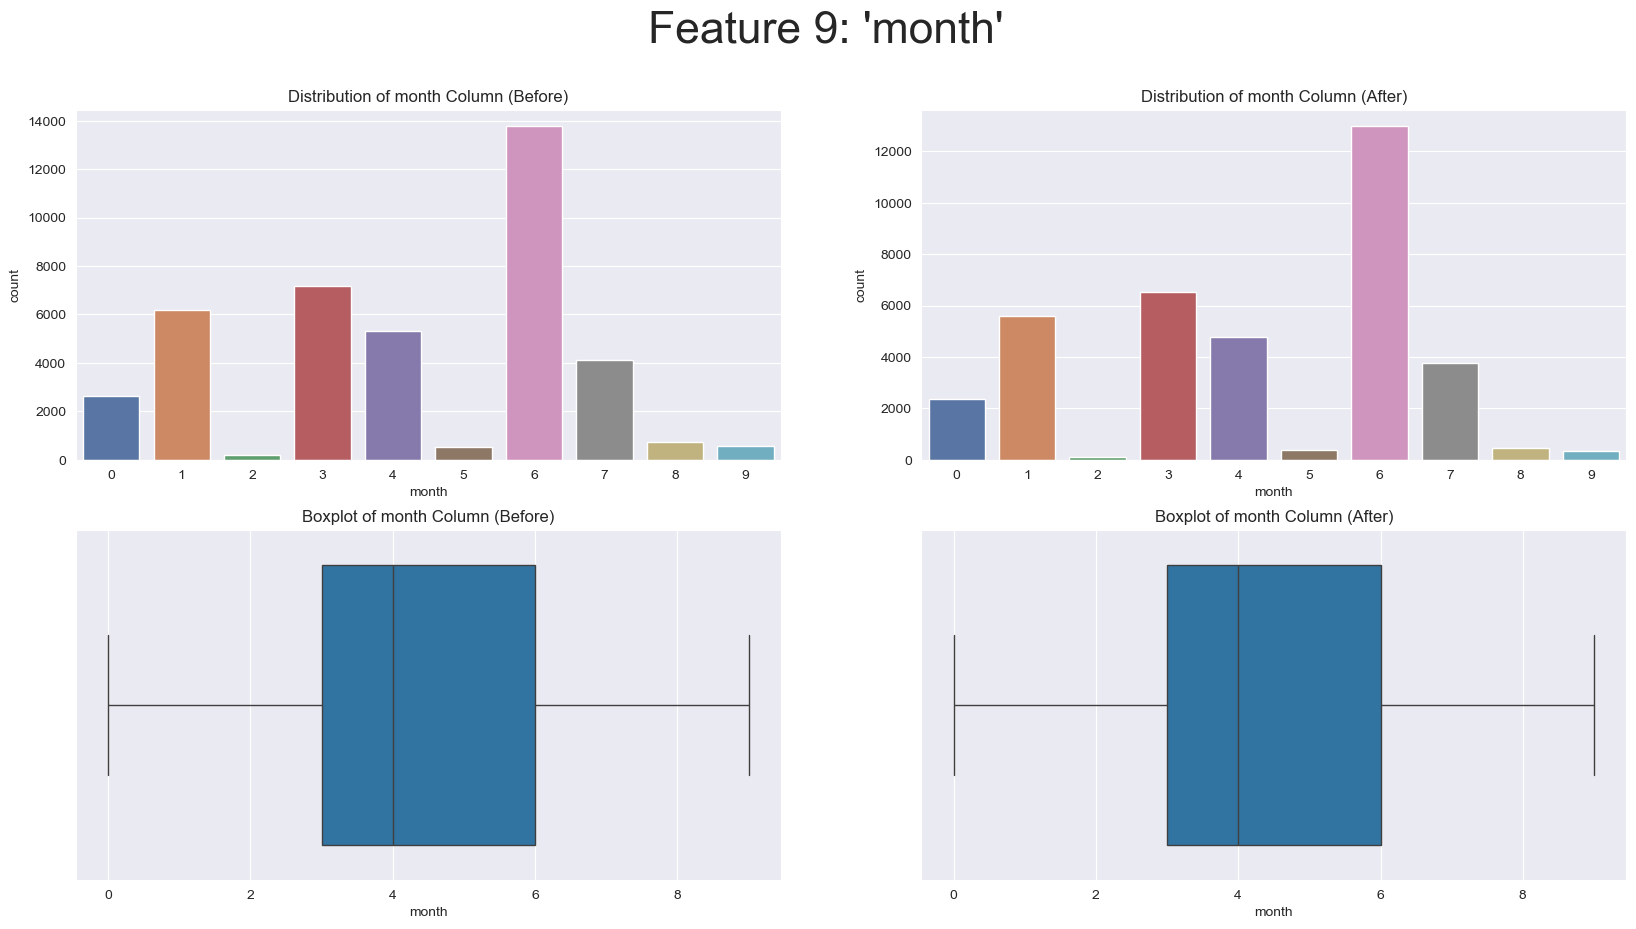

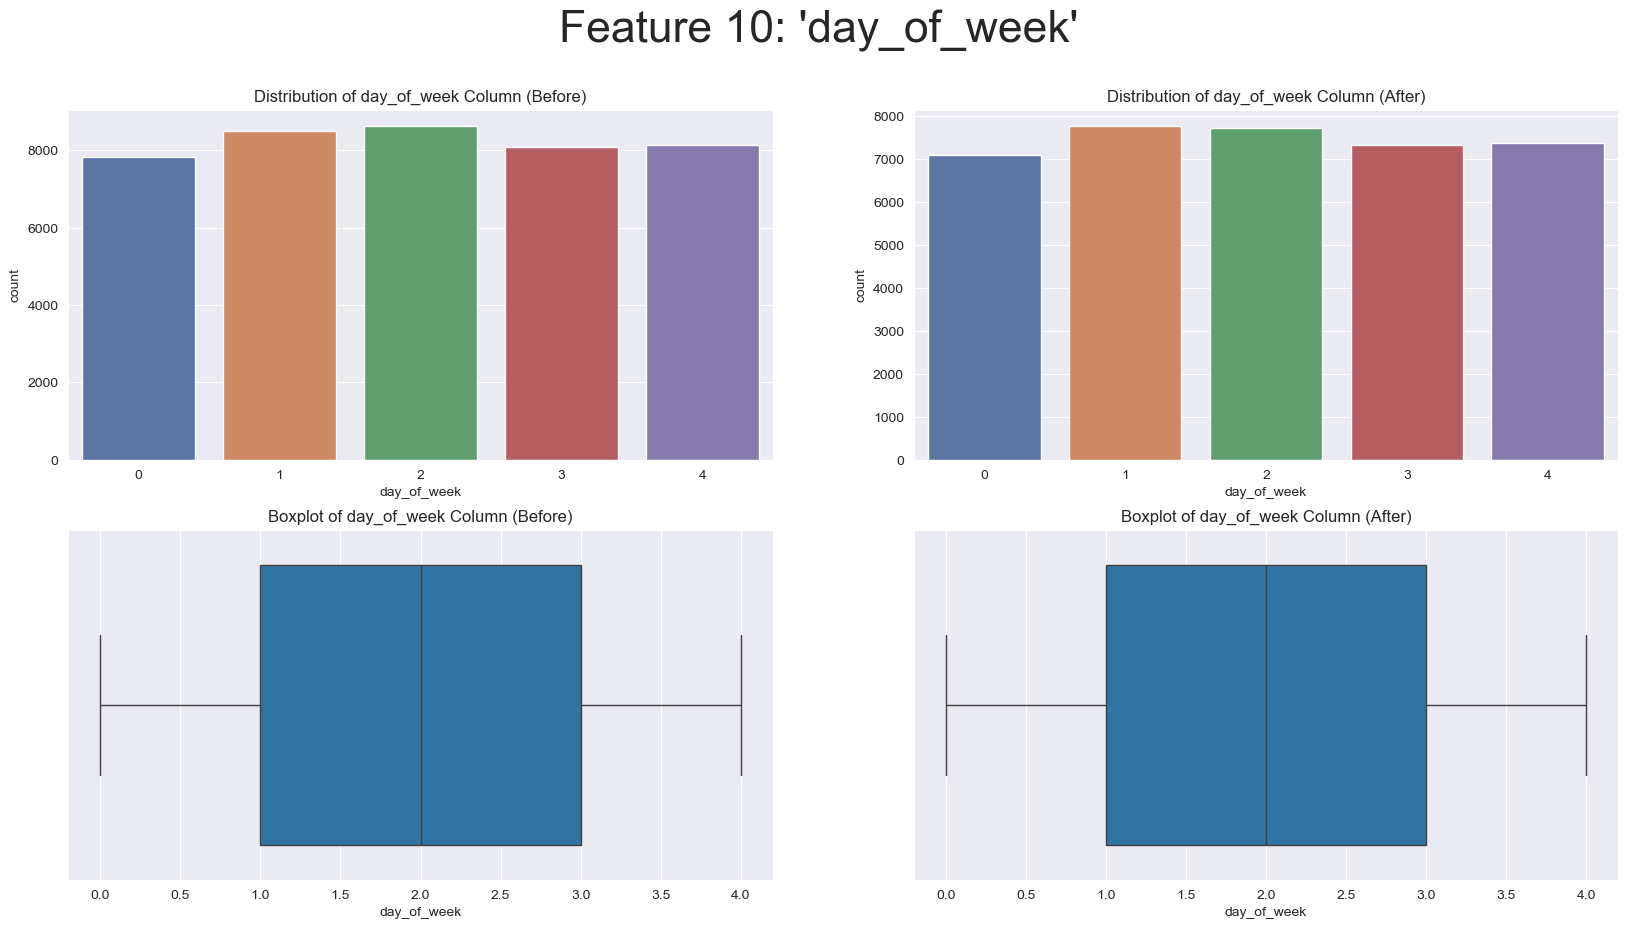

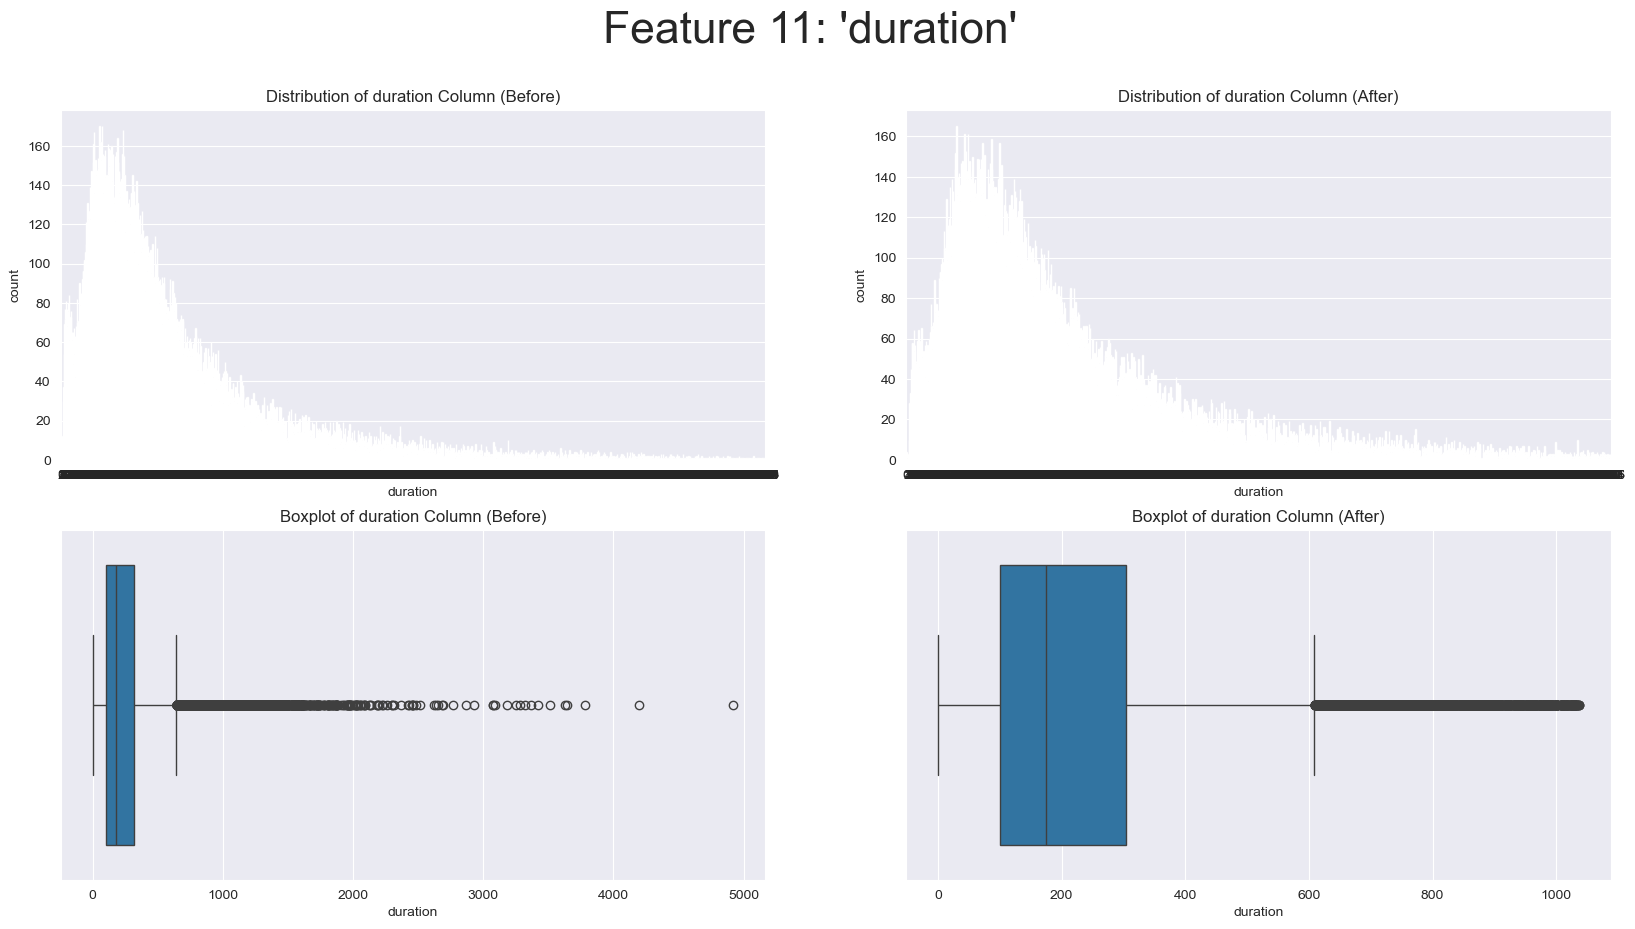

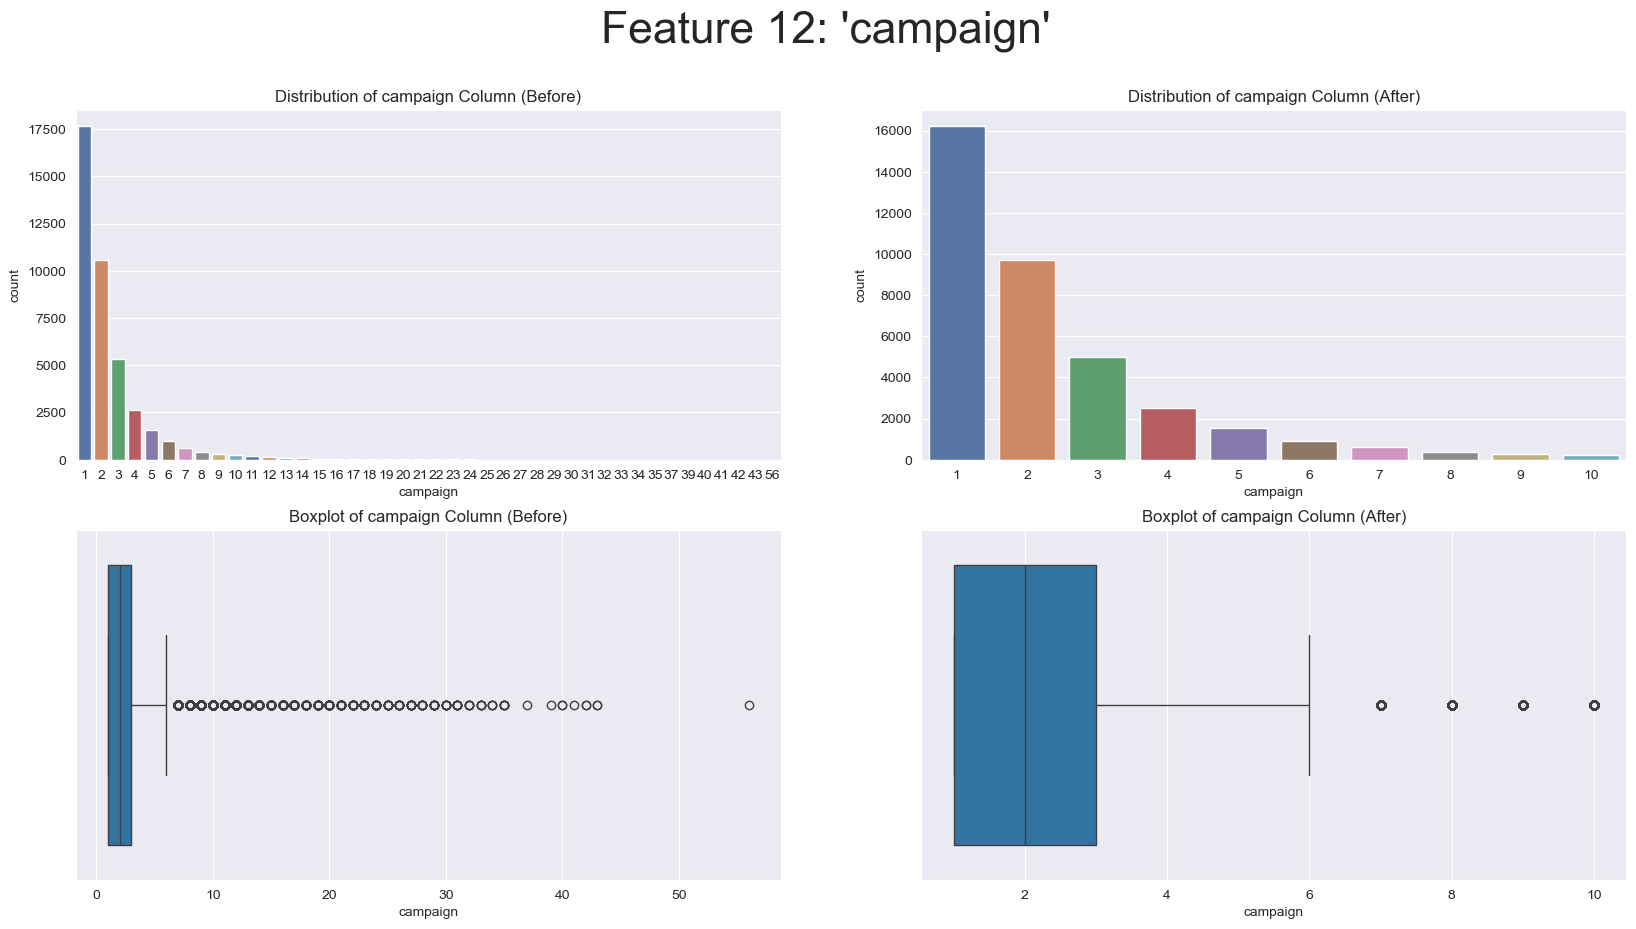

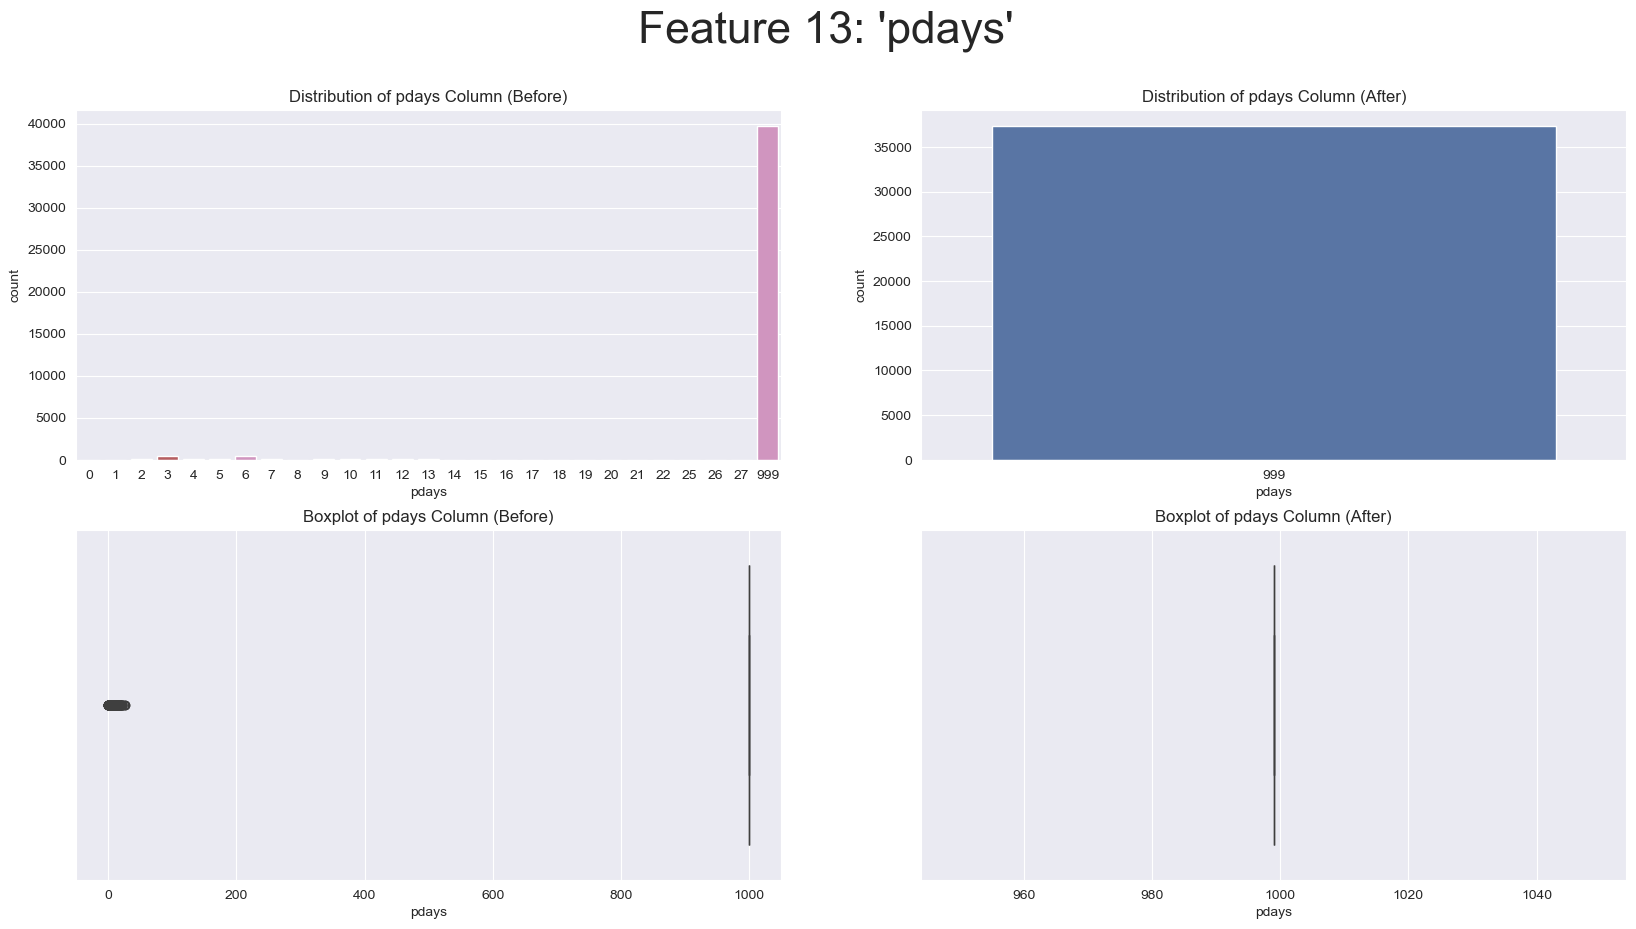

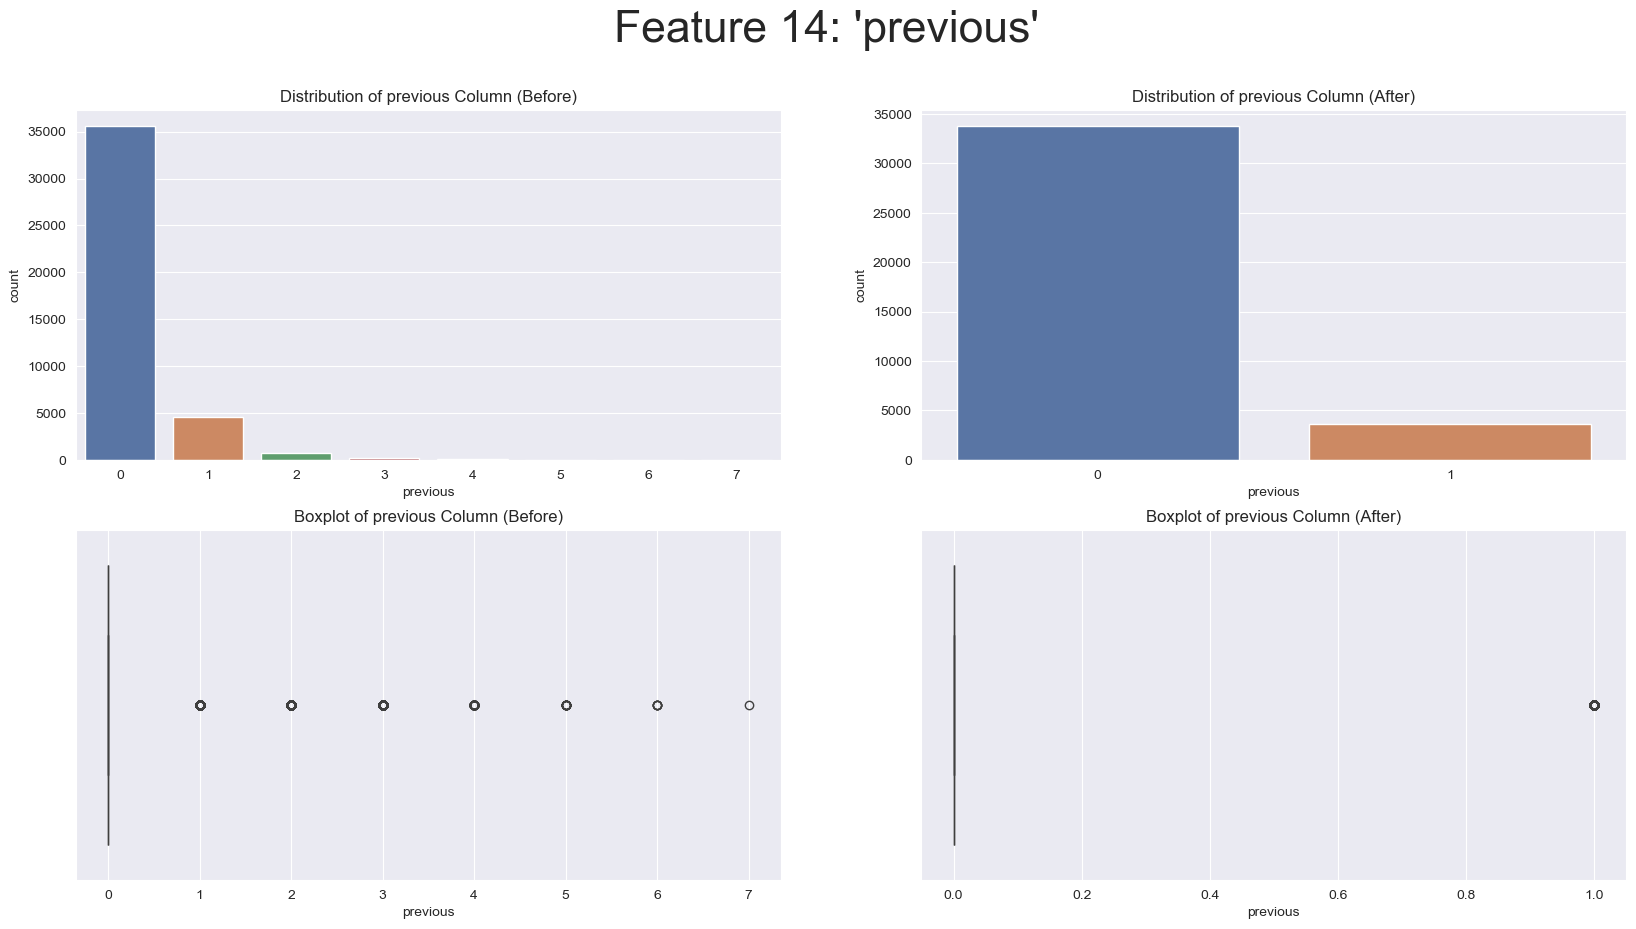

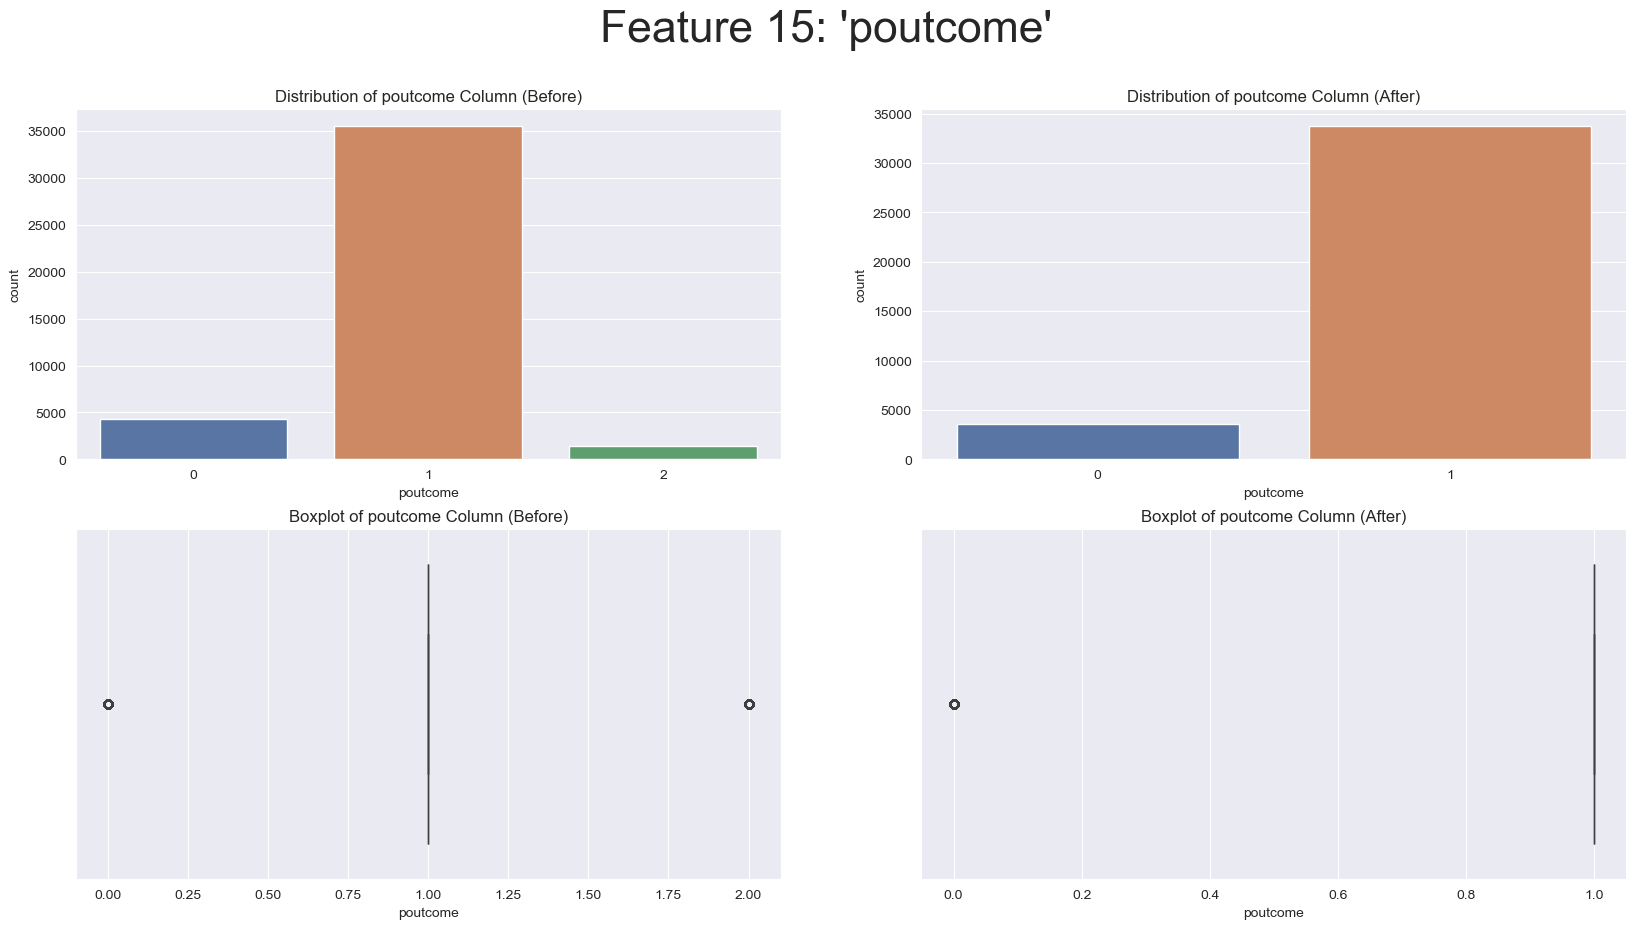

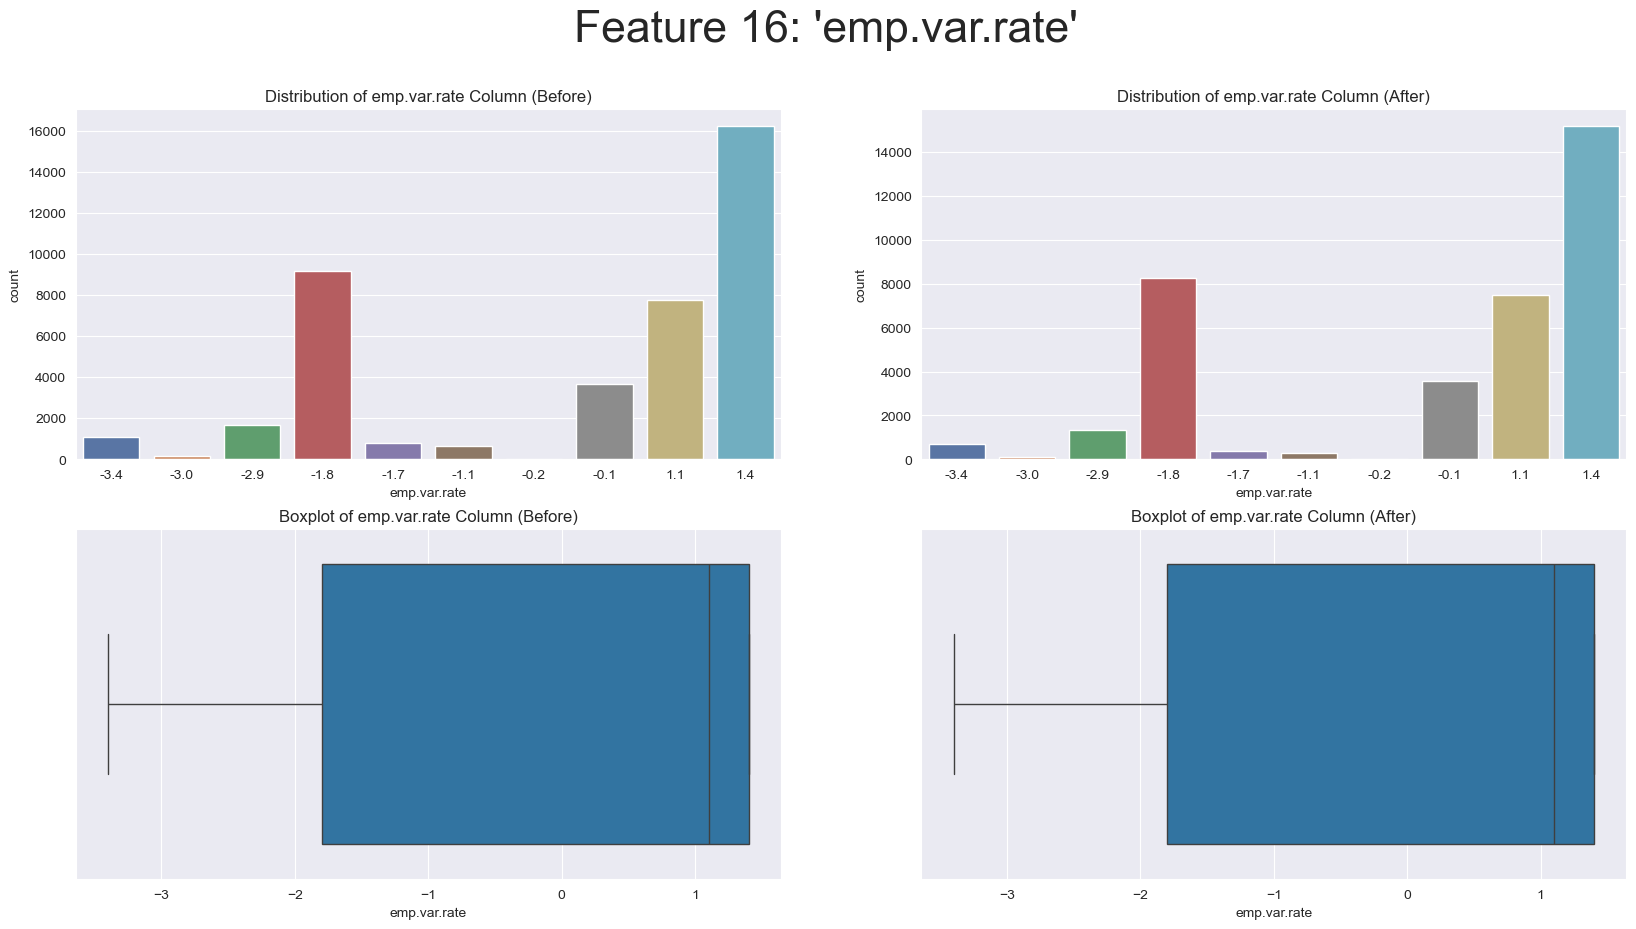

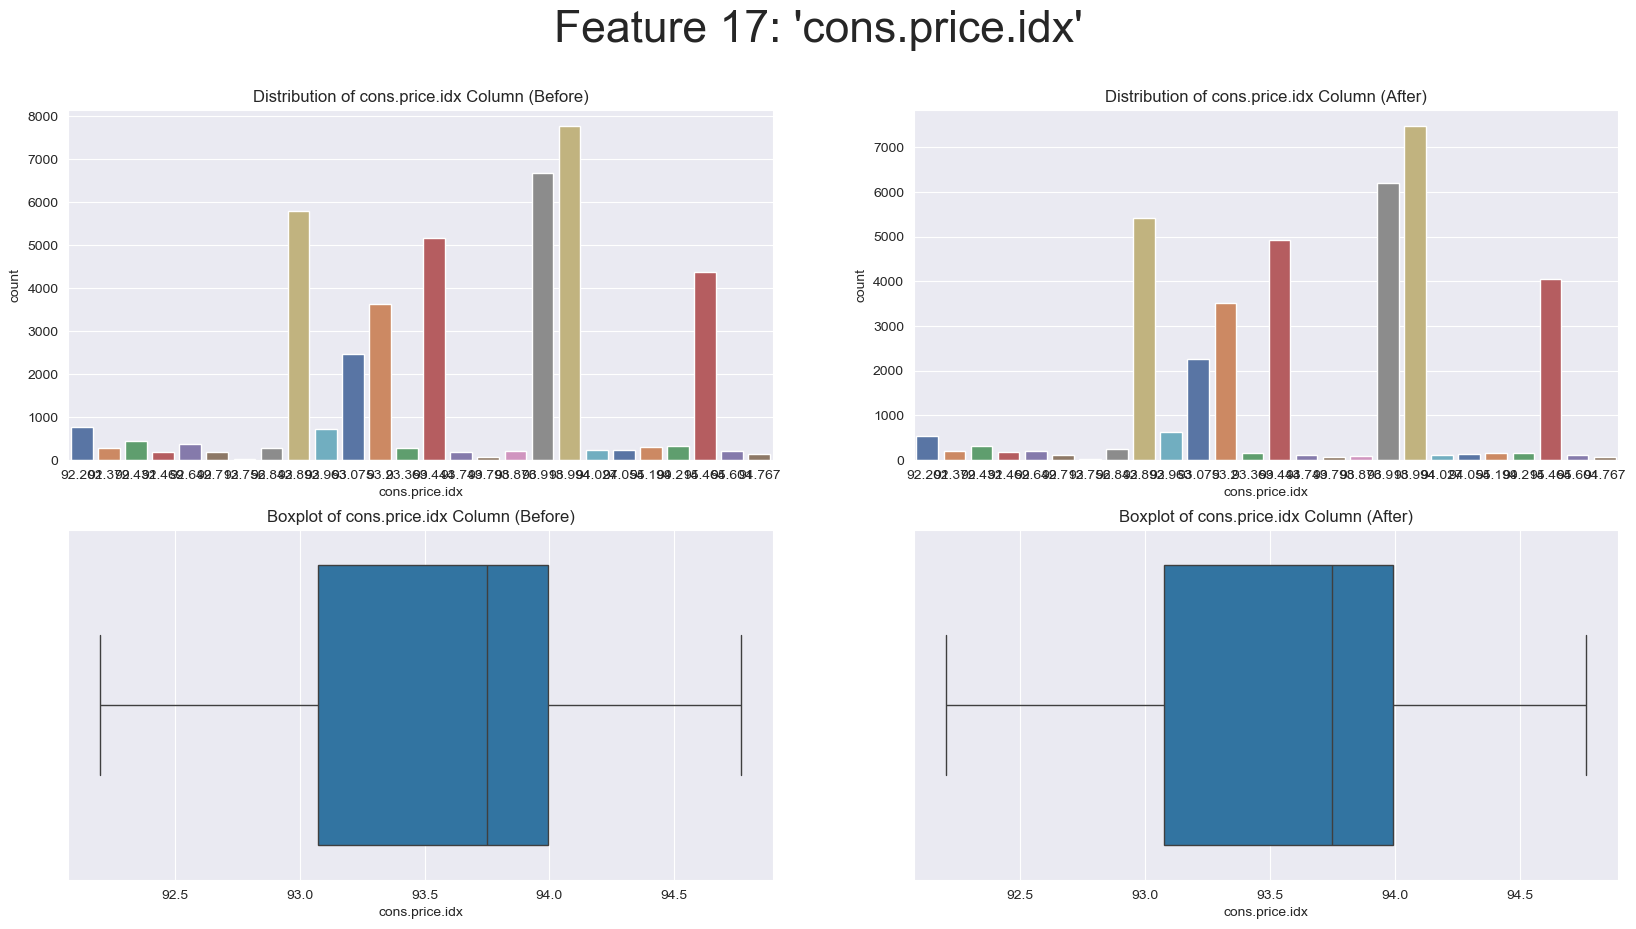

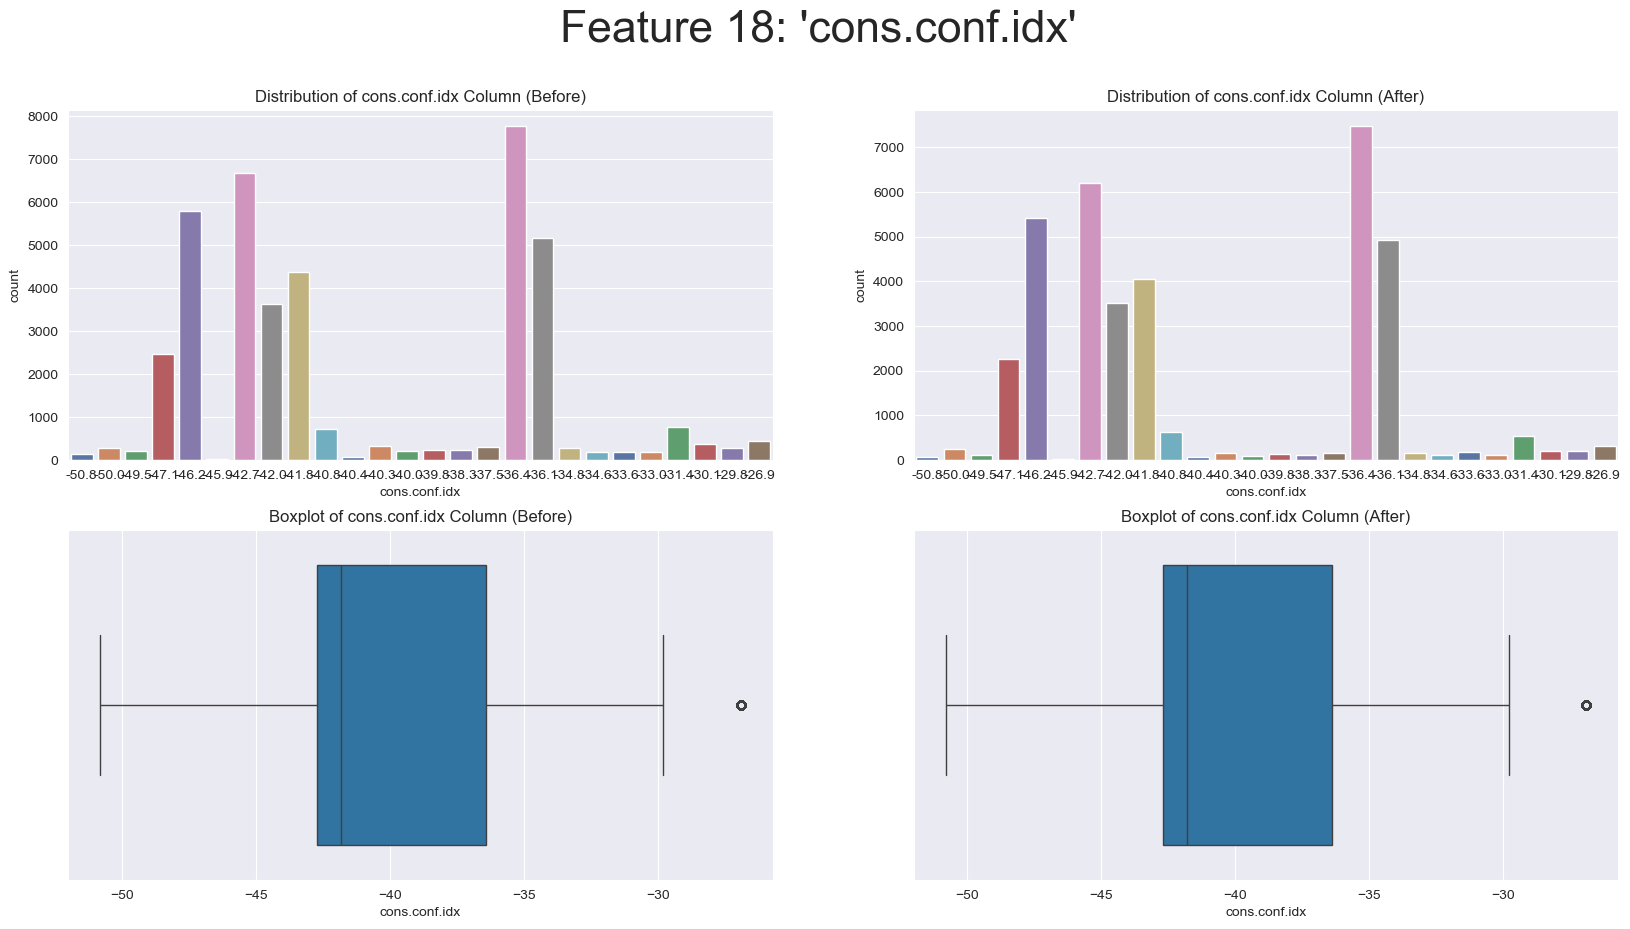

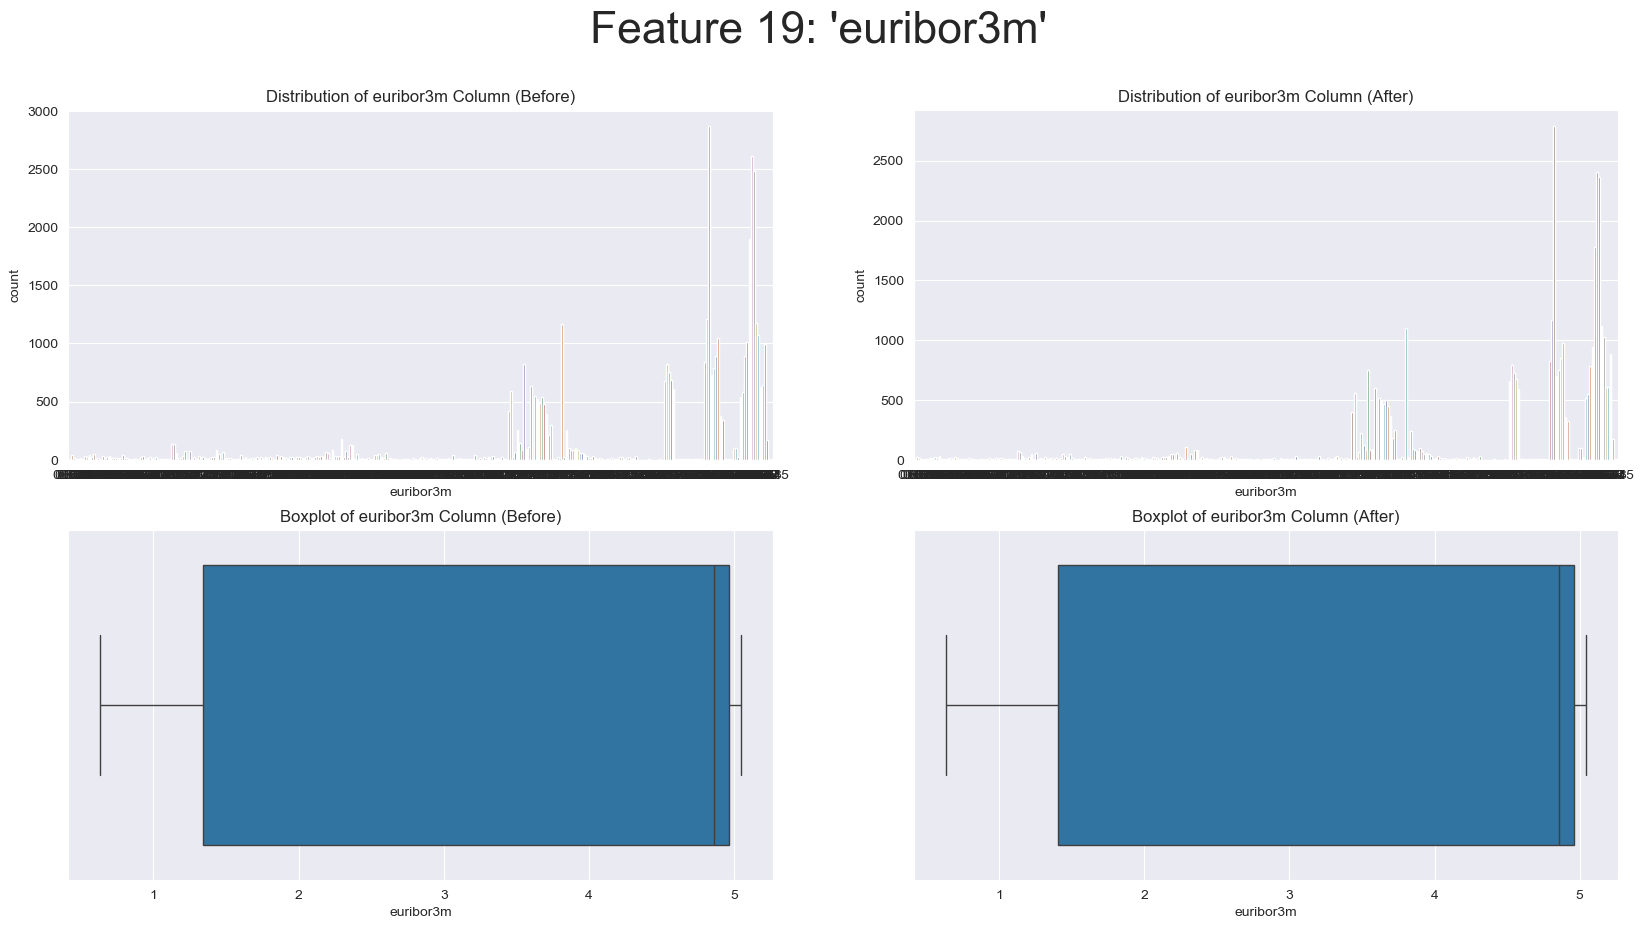

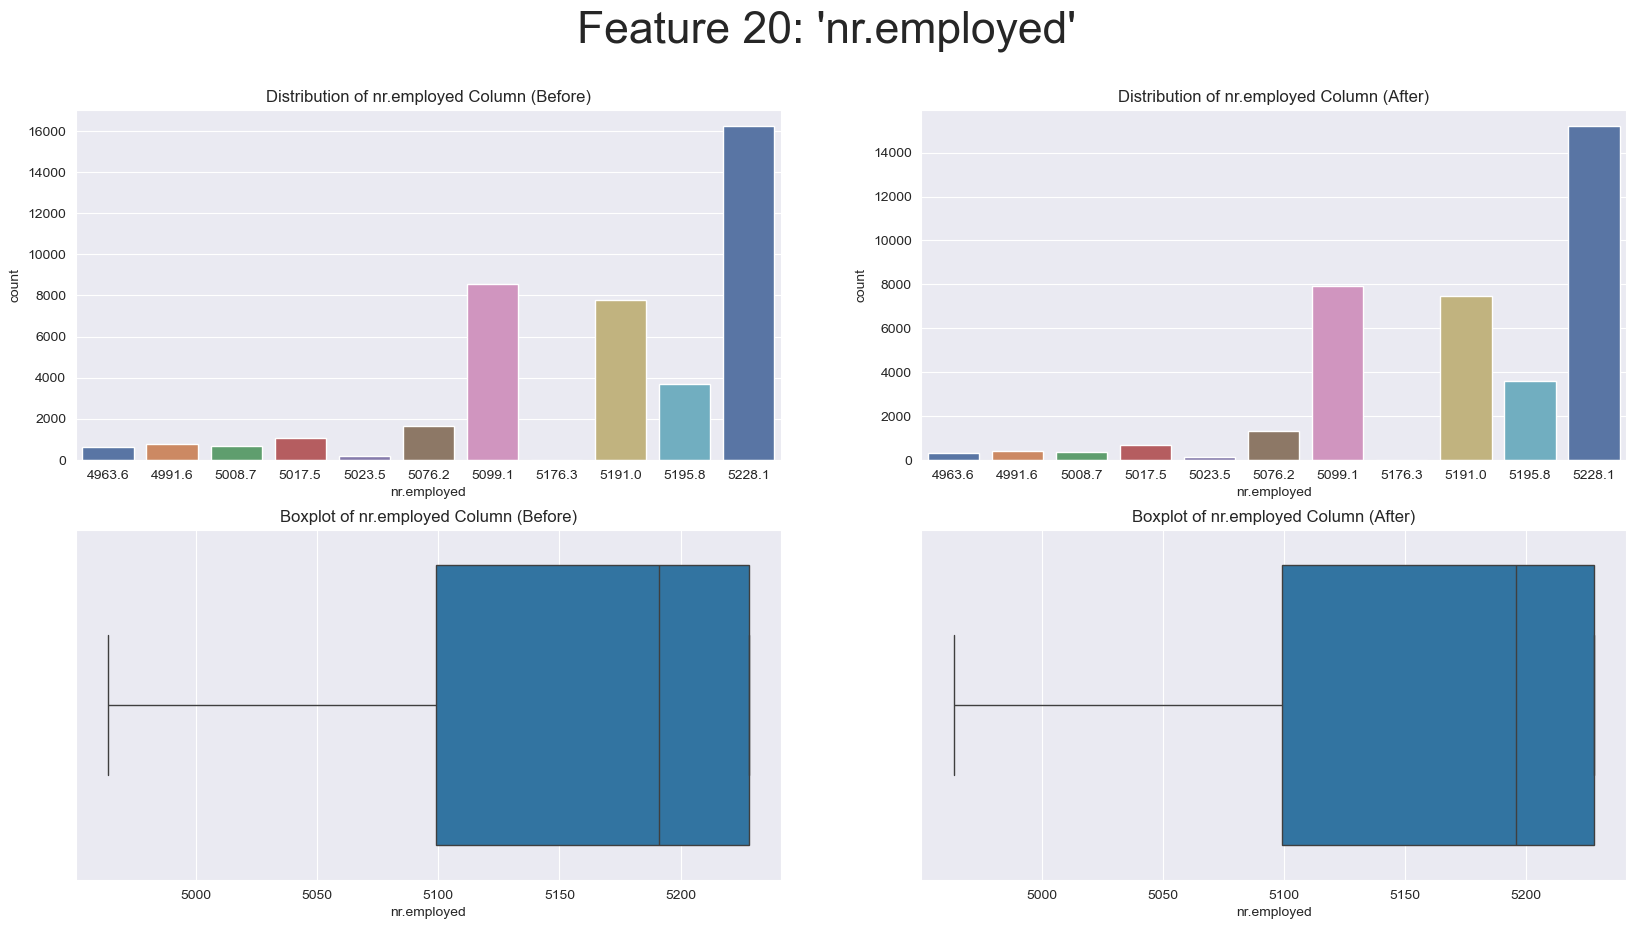

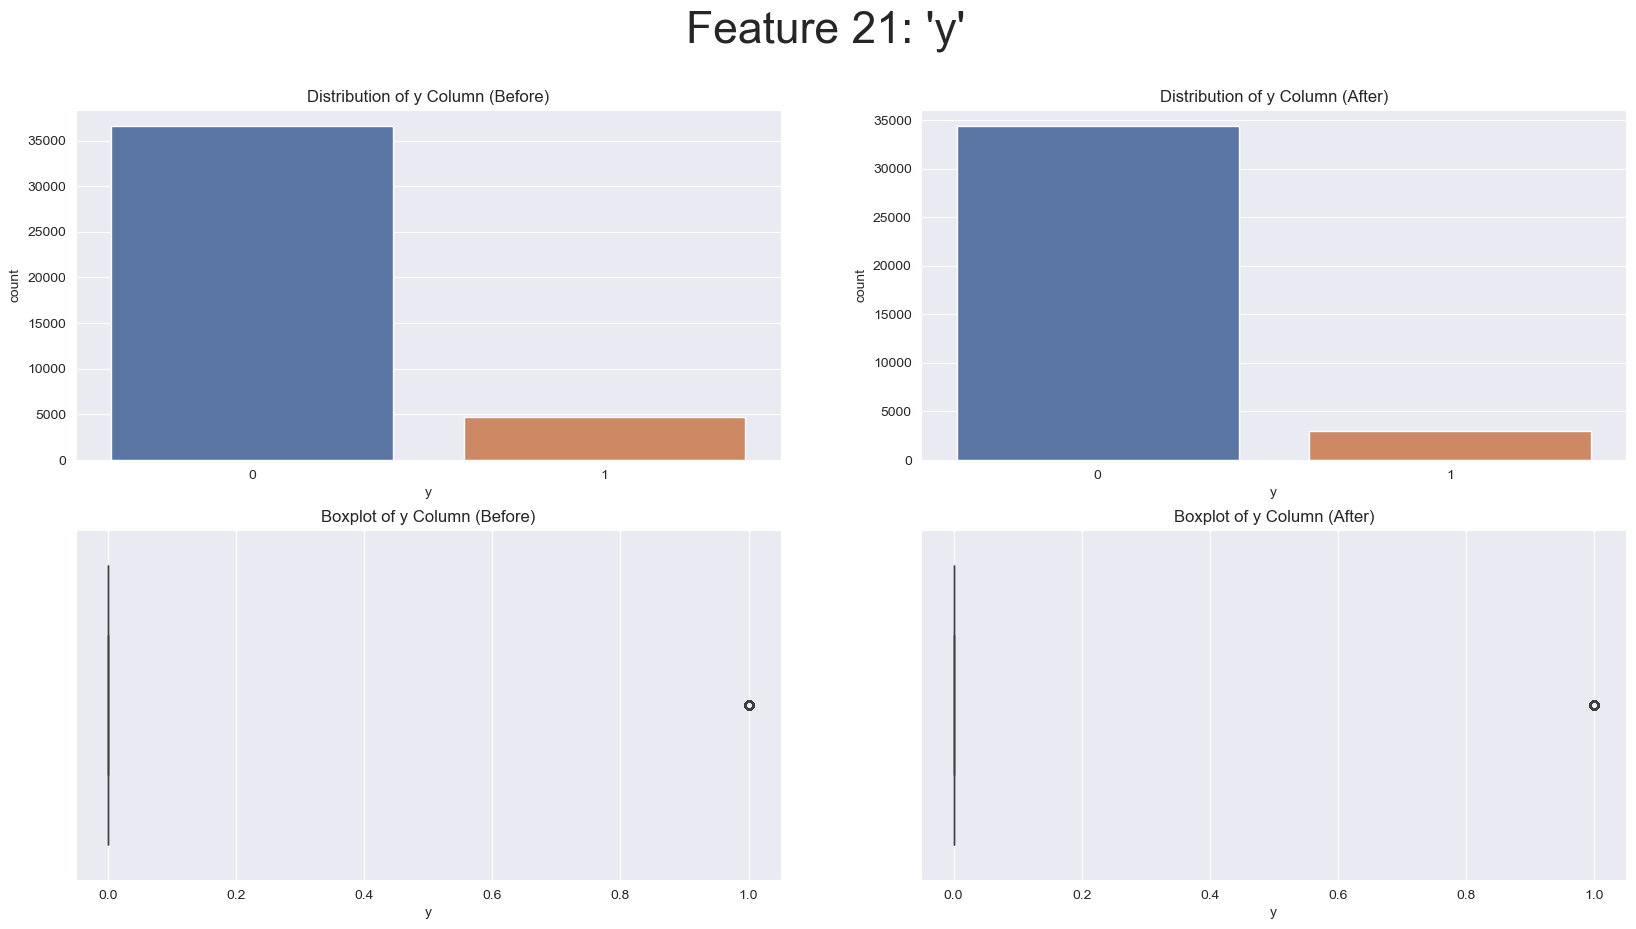

In [328]:
import warnings
# Suppress UserWarnings from Seaborn
warnings.filterwarnings("ignore", category=UserWarning)
i = 1
for col in dataset.columns:
    fig, ax = plt.subplots(2,2, figsize=(20, 10))

    # Before outlier removal
    sns.countplot(data=dataset_with_outliers, x=col, palette="deep", hue=col, ax=ax[0,0])
    ax[0,0].set_title(f"Distribution of {col} Column (Before)")
    ax[0, 0].legend_.remove()

    # After outlier removal
    sns.countplot(data=dataset_no_outliers, x=col, palette="deep", hue=col, ax=ax[0,1])
    ax[0,1].set_title(f"Distribution of {col} Column (After)")
    ax[0, 1].legend_.remove()

    # Before outlier removal
    sns.boxplot(data=dataset_with_outliers, x=col, ax=ax[1,0])
    ax[1,0].set_title(f"Boxplot of {col} Column (Before)")

    # After outlier removal
    sns.boxplot(data=dataset_no_outliers, x=col, ax=ax[1,1])
    ax[1,1].set_title(f"Boxplot of {col} Column (After)")

    plt.suptitle(f"Feature {i}: '{col}'", fontsize=32)
    i = i + 1
    plt.show()

In [329]:
dataset_clean = dataset_no_outliers.copy()

## Summary:
#### Work done:
* Encoding categorical features, so that we can visualize the distribution, and prepared the feature to use in feature episodes
* Handle missing value by imputing mode
* Handle outliers, even though there are still some outliers, we get rid of the most of them. If we tried to removed all of them we lost the %40 of our data, that's why we remained some of them in the feature episodes we'll deak with them using robust scaler
###
#### Feature to be modified:
* Default:          We'll remove it from the dataset, since it has only one unique value.
* Duration:         We'll try to get more balance feature distribution.
* "Campaign":       In 'campaign' column after dealing values there are still some outlier values, we'll deal with them using robust scaler.
* "pdays:           In 'pdays' column we have the same problem with 'default' feature 
* "emp.var.rate":   We'll try to get more balance feature distribution.
* "cons.price.idx": We'll try to get more balance feature distribution.
* "cons.conf.idx":  We'll try to get more balance feature distribution.
* "euribor3m":      We'll try to get more balance feature distribution.
* "nr.employed":    We'll try to get more balance feature distribution.

# -----------------------------------------------------------------------------------------------------------------

## Feature Extraction:

In [330]:
def extract_feature_by_thresholds(df,col_name,thresholds):
    flag = 0
    for i in range(len(thresholds) - 1):
        lower_bound = thresholds[i]
        upper_bound = thresholds[i + 1]
        label = i
        if flag == 0:
            mask = (df[col_name] >= lower_bound) & (df[col_name] <= upper_bound) # Hold true or false for values which satisfies the rule or not satisfies
            flag = 1
        else:
            mask = (df[col_name] > lower_bound) & (df[col_name] <= upper_bound)
        df.loc[mask, f'{col_name}_group'] = label # Labeling values which are only the true type in the corresponding columns
    df[f'{col_name}_group'] = df[f'{col_name}_group'].astype(int)

In [331]:
def print_extract_feature_by_thresholds(df,col_name,thresholds):
    total_samples = len(df)
    flag = 0
    for i in range(len(thresholds) - 1):
        lower_bound = thresholds[i]
        upper_bound = thresholds[i + 1]
        if flag == 0:
            mask = (df[col_name] >= lower_bound) & (df[col_name] <= upper_bound)
            flag = 1
        else:
            mask = (df[col_name] > lower_bound) & (df[col_name] <= upper_bound)
        count = df.loc[mask].shape[0]
        percentage = (count / total_samples)
        rounded_percentage = round(percentage, 4)
        print(f"({lower_bound}_{upper_bound}] = {rounded_percentage}, samples:{count}")

In [332]:
def generate_threshold(df,col_name,increment_range):
    start = df[col_name].min() - (df[col_name].min())%increment_range
    end   = df[col_name].max() - (df[col_name].max())%increment_range + increment_range
    
    thresholds = []
    threshold = start
    while threshold <= end:
        thresholds.append(threshold)
        threshold += increment_range
    return thresholds

In [333]:
def visualize_extracted_columns_distribution(df_before,df_after,col_name):
    fig, ax = plt.subplots(1,2, figsize=(20, 5))

    # Before extraction feature
    sns.countplot(data=df_before, x=col_name, palette="Set2", hue=col_name,  ax=ax[0])
    ax[0].set_title(f"Distribution of {col_name} Column (Before)")
    ax[0].legend_.remove()
    
    # After extraction feature
    sns.countplot(data=df_after, x=col_name+'_group',palette="Set2", hue=col_name+'_group', ax=ax[1])
    ax[1].set_title(f"Distribution of {col_name+'_group'} Column (After)")
    ax[1].legend_.remove()
    
    plt.show()

In [334]:
dataset_no_modified = dataset_clean.copy()
dataset_modified    = dataset_clean.copy()

##### 1-) "Default"

In [335]:
dataset_modified.drop(['default'], axis=1, inplace=True) 

##### 2-) "duration"

In [336]:
duration_threshold = generate_threshold(dataset_modified,'duration',100)
print(f"Duration threshold:\t{duration_threshold}")
print_extract_feature_by_thresholds(dataset_modified,'duration',duration_threshold)

Duration threshold:	[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100]
(0_100] = 0.2479, samples:9248
(100_200] = 0.3203, samples:11949
(200_300] = 0.178, samples:6643
(300_400] = 0.0992, samples:3701
(400_500] = 0.0547, samples:2042
(500_600] = 0.0358, samples:1336
(600_700] = 0.025, samples:933
(700_800] = 0.0171, samples:638
(800_900] = 0.0116, samples:433
(900_1000] = 0.0081, samples:303
(1000_1100] = 0.0023, samples:85


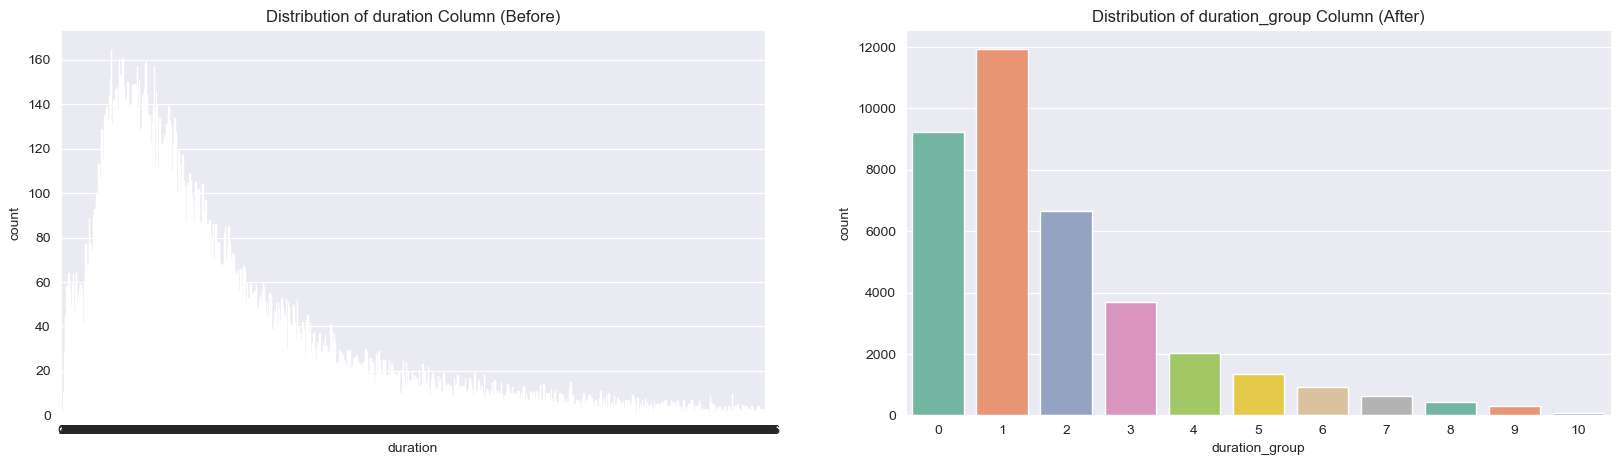

In [337]:
extract_feature_by_thresholds(dataset_modified,'duration',duration_threshold)
visualize_extracted_columns_distribution(dataset_no_modified,dataset_modified,'duration')

##### 3-) "pdays"

In [338]:
dataset_modified.drop(['pdays'],axis=1, inplace=True)

##### 4-) "emp.var.rate"

In [339]:
emp_rate_threshold = generate_threshold(dataset_modified,'emp.var.rate',5)
print(f"emp.var.rate threshold:\t{emp_rate_threshold}")
print_extract_feature_by_thresholds(dataset_modified,'emp.var.rate',emp_rate_threshold)

emp.var.rate threshold:	[-5.0, 0.0, 5.0]
(-5.0_0.0] = 0.3924, samples:14640
(0.0_5.0] = 0.6076, samples:22671


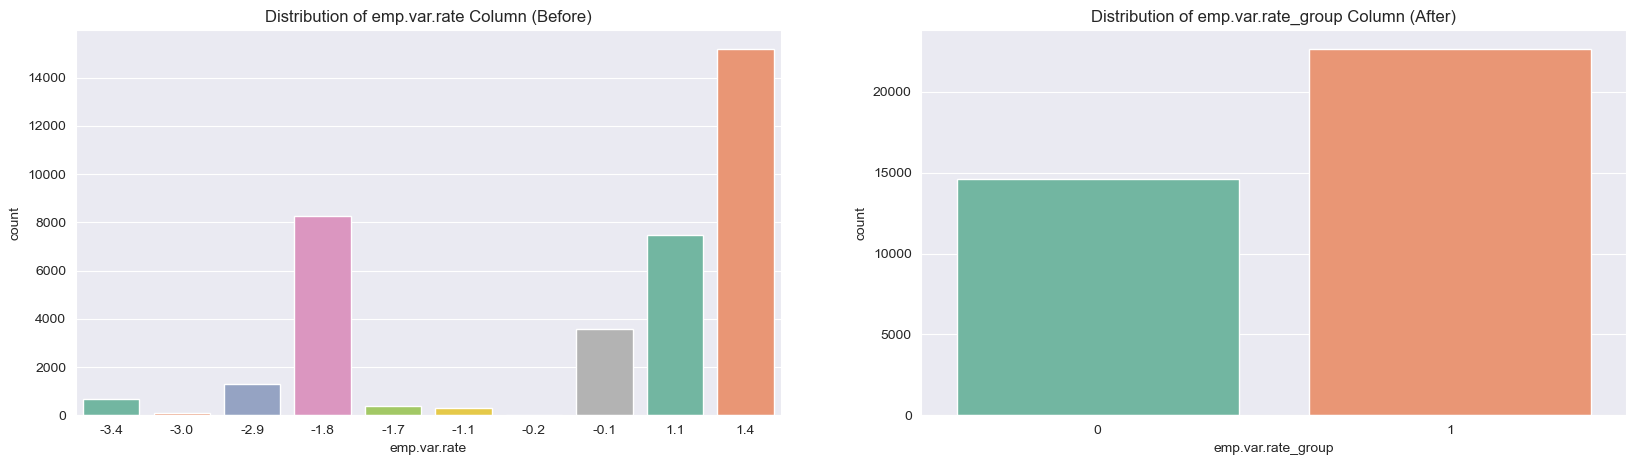

In [340]:
extract_feature_by_thresholds(dataset_modified,'emp.var.rate',emp_rate_threshold)
visualize_extracted_columns_distribution(dataset_no_modified,dataset_modified,'emp.var.rate')

##### 5-) "cons.price.idx"

In [341]:
cons_price_threshold = generate_threshold(dataset_modified,'cons.price.idx',1)
print(f"cons.price.idx threshold:\t{cons_price_threshold}")
print_extract_feature_by_thresholds(dataset_modified,'cons.price.idx',cons_price_threshold)

cons.price.idx threshold:	[92.0, 93.0, 94.0, 95.0]
(92.0_93.0] = 0.2084, samples:7776
(93.0_94.0] = 0.6642, samples:24781
(94.0_95.0] = 0.1274, samples:4754


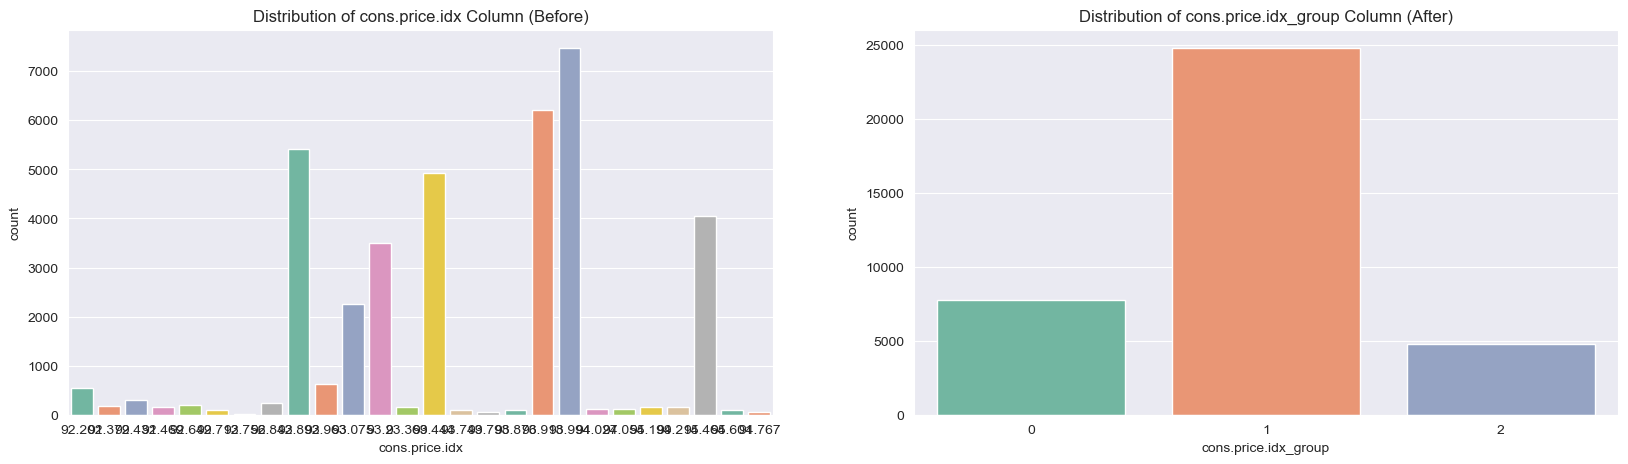

In [342]:
extract_feature_by_thresholds(dataset_modified,'cons.price.idx',cons_price_threshold)
visualize_extracted_columns_distribution(dataset_no_modified,dataset_modified,'cons.price.idx')

##### 6-) "cons.conf.idx"

In [343]:
cons_conf_threshold = generate_threshold(dataset_modified,'cons.conf.idx',20)
print(f"cons.conf.idx threshold:\t{cons_conf_threshold}")
print_extract_feature_by_thresholds(dataset_modified,'cons.conf.idx',cons_conf_threshold)

cons.conf.idx threshold:	[-60.0, -40.0, -20.0]
(-60.0_-40.0] = 0.6104, samples:22775
(-40.0_-20.0] = 0.3896, samples:14536


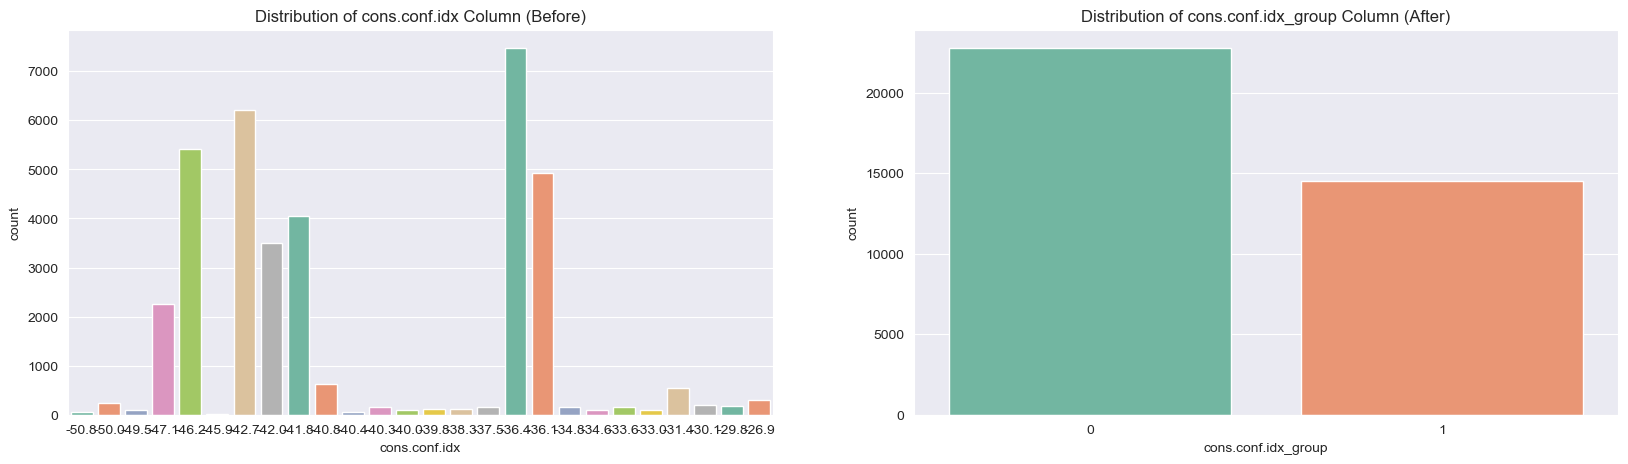

In [344]:
extract_feature_by_thresholds(dataset_modified,'cons.conf.idx',cons_conf_threshold)
visualize_extracted_columns_distribution(dataset_no_modified,dataset_modified,'cons.conf.idx')

##### 7-) "euribor3m"

In [345]:
euribor_threshold = generate_threshold(dataset_modified,'euribor3m',0.125)
print(f"euribor3m threshold:\t{euribor_threshold}")
print_extract_feature_by_thresholds(dataset_modified,'euribor3m',euribor_threshold)

euribor3m threshold:	[0.625, 0.75, 0.875, 1.0, 1.125, 1.25, 1.375, 1.5, 1.625, 1.75, 1.875, 2.0, 2.125, 2.25, 2.375, 2.5, 2.625, 2.75, 2.875, 3.0, 3.125, 3.25, 3.375, 3.5, 3.625, 3.75, 3.875, 4.0, 4.125, 4.25, 4.375, 4.5, 4.625, 4.75, 4.875, 5.0, 5.125]
(0.625_0.75] = 0.0282, samples:1051
(0.75_0.875] = 0.0166, samples:618
(0.875_1.0] = 0.0174, samples:650
(1.0_1.125] = 0.0062, samples:230
(1.125_1.25] = 0.0266, samples:993
(1.25_1.375] = 0.1415, samples:5280
(1.375_1.5] = 0.0534, samples:1994
(1.5_1.625] = 0.0031, samples:115
(1.625_1.75] = 0.0017, samples:65
(1.75_1.875] = 0.0017, samples:64
(1.875_2.0] = 0.0, samples:0
(2.0_2.125] = 0.0, samples:0
(2.125_2.25] = 0.0, samples:0
(2.25_2.375] = 0.0, samples:0
(2.375_2.5] = 0.0, samples:0
(2.5_2.625] = 0.0, samples:0
(2.625_2.75] = 0.0, samples:0
(2.75_2.875] = 0.0, samples:0
(2.875_3.0] = 0.0, samples:0
(3.0_3.125] = 0.0, samples:1
(3.125_3.25] = 0.0, samples:0
(3.25_3.375] = 0.0001, samples:2
(3.375_3.5] = 0.0001, samples:2
(3.5_3.625

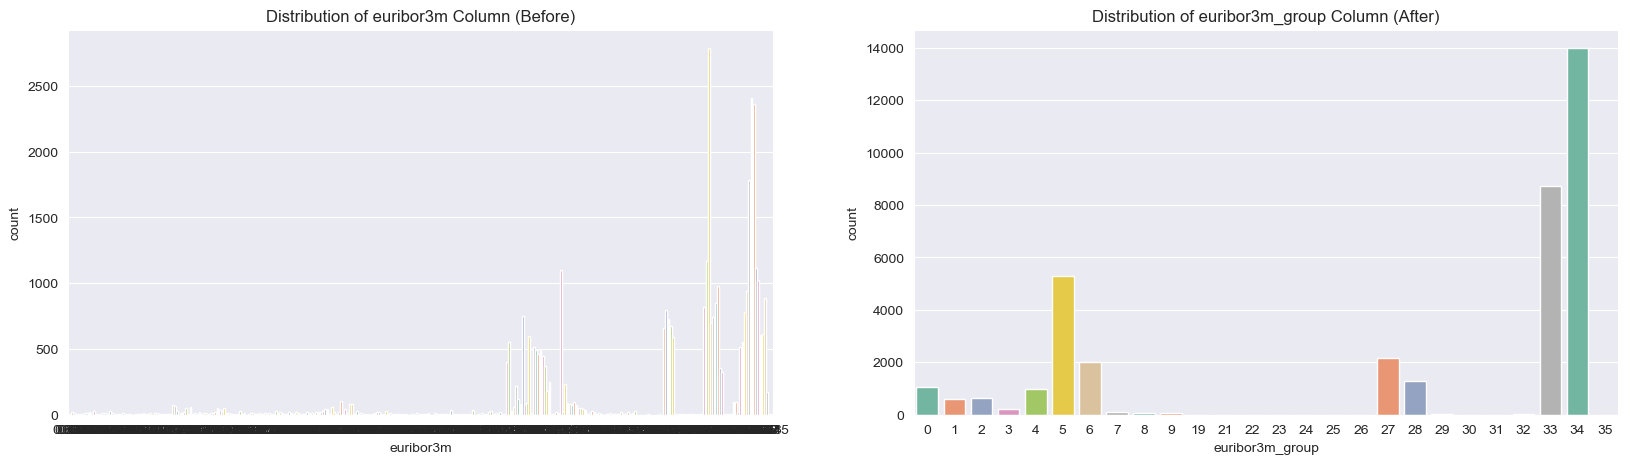

In [346]:
extract_feature_by_thresholds(dataset_modified,'euribor3m',euribor_threshold)
visualize_extracted_columns_distribution(dataset_no_modified,dataset_modified,'euribor3m')

##### 8-) "nr.employed"

In [347]:
employed_threshold = generate_threshold(dataset_modified,'nr.employed',50)
print(f"nr.employed threshold:\t{employed_threshold}")
print_extract_feature_by_thresholds(dataset_modified,'nr.employed',employed_threshold)

nr.employed threshold:	[4950.0, 5000.0, 5050.0, 5100.0, 5150.0, 5200.0, 5250.0]
(4950.0_5000.0] = 0.0187, samples:697
(5000.0_5050.0] = 0.0306, samples:1142
(5050.0_5100.0] = 0.2471, samples:9221
(5100.0_5150.0] = 0.0, samples:0
(5150.0_5200.0] = 0.2962, samples:11052
(5200.0_5250.0] = 0.4074, samples:15199


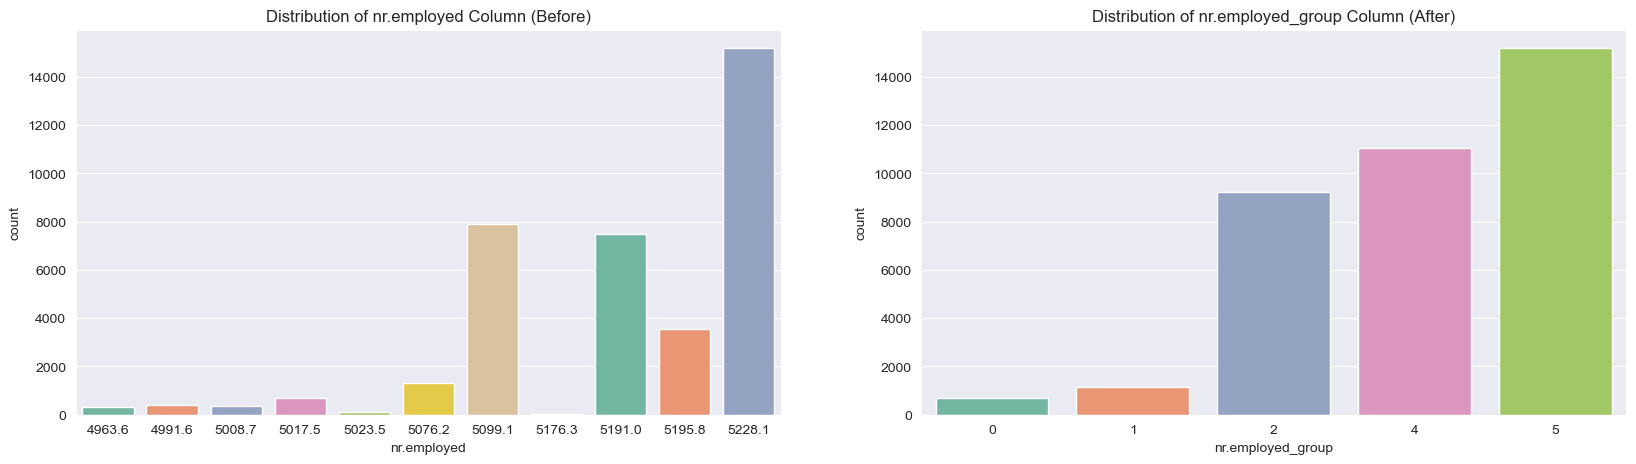

In [348]:
extract_feature_by_thresholds(dataset_modified,'nr.employed',employed_threshold)
visualize_extracted_columns_distribution(dataset_no_modified,dataset_modified,'nr.employed')

In [349]:
dataset_modified.dtypes

age                       int64
duration                  int64
campaign                  int64
previous                  int64
emp.var.rate            float64
cons.price.idx          float64
cons.conf.idx           float64
euribor3m               float64
nr.employed             float64
job                       int32
marital                   int32
education                 int32
housing                   int32
loan                      int32
contact                   int32
month                     int32
day_of_week               int32
poutcome                  int32
y                         int32
duration_group            int32
emp.var.rate_group        int32
cons.price.idx_group      int32
cons.conf.idx_group       int32
euribor3m_group           int32
nr.employed_group         int32
dtype: object

### Summary:
#### Work done:
* Extracted new features: {duration_group, emp.var.rate_group, cons.price.idx_group, cons.conf.idx_group, euribor3m_group, nr.employed_group}
* Removed features: {default,pdays}

# ---------------------------------------------------------------------------------------------------------------------------------

# Feature Reduction & Selection:

In [350]:
dataset_no_selection = dataset_modified.copy()

<Axes: >

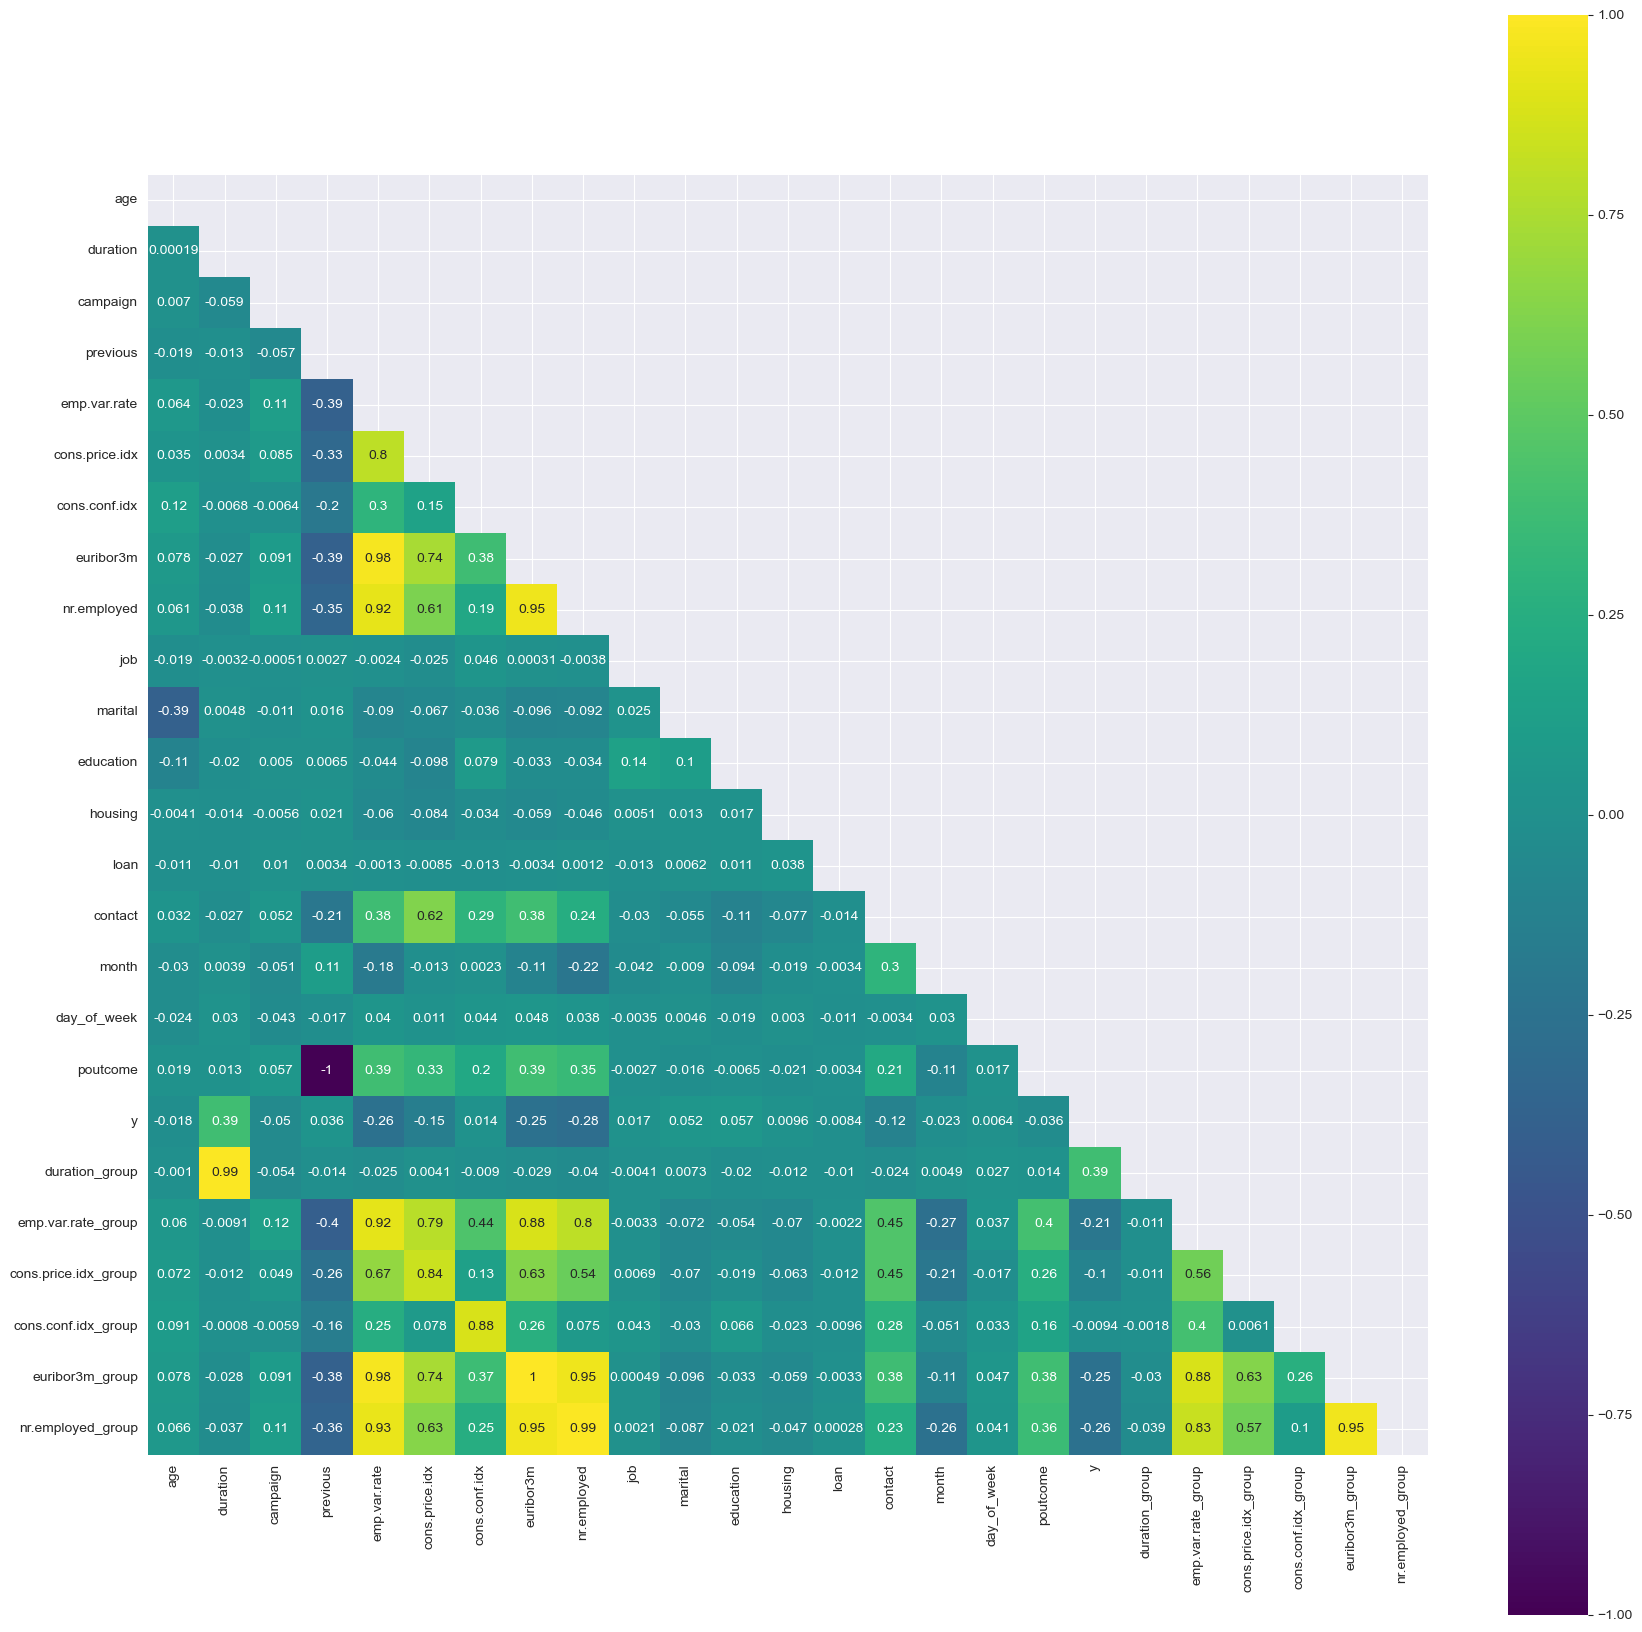

In [351]:
fig= plt.figure(figsize=(16,16))
corr = dataset_no_selection.corr()
mask = np.triu(dataset_no_selection.corr())

axes = fig.add_axes([0, 0, 1, 1])
sns.heatmap(corr, annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='viridis',
            linecolor='white', cbar_kws= {'orientation': 'vertical'}, ax=axes)

In [352]:
# Remove the one of the high correlated features
dataset_selected = dataset_no_selection.drop(['duration','poutcome','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed','euribor3m_group','emp.var.rate_group'], axis=1).copy()

<Axes: >

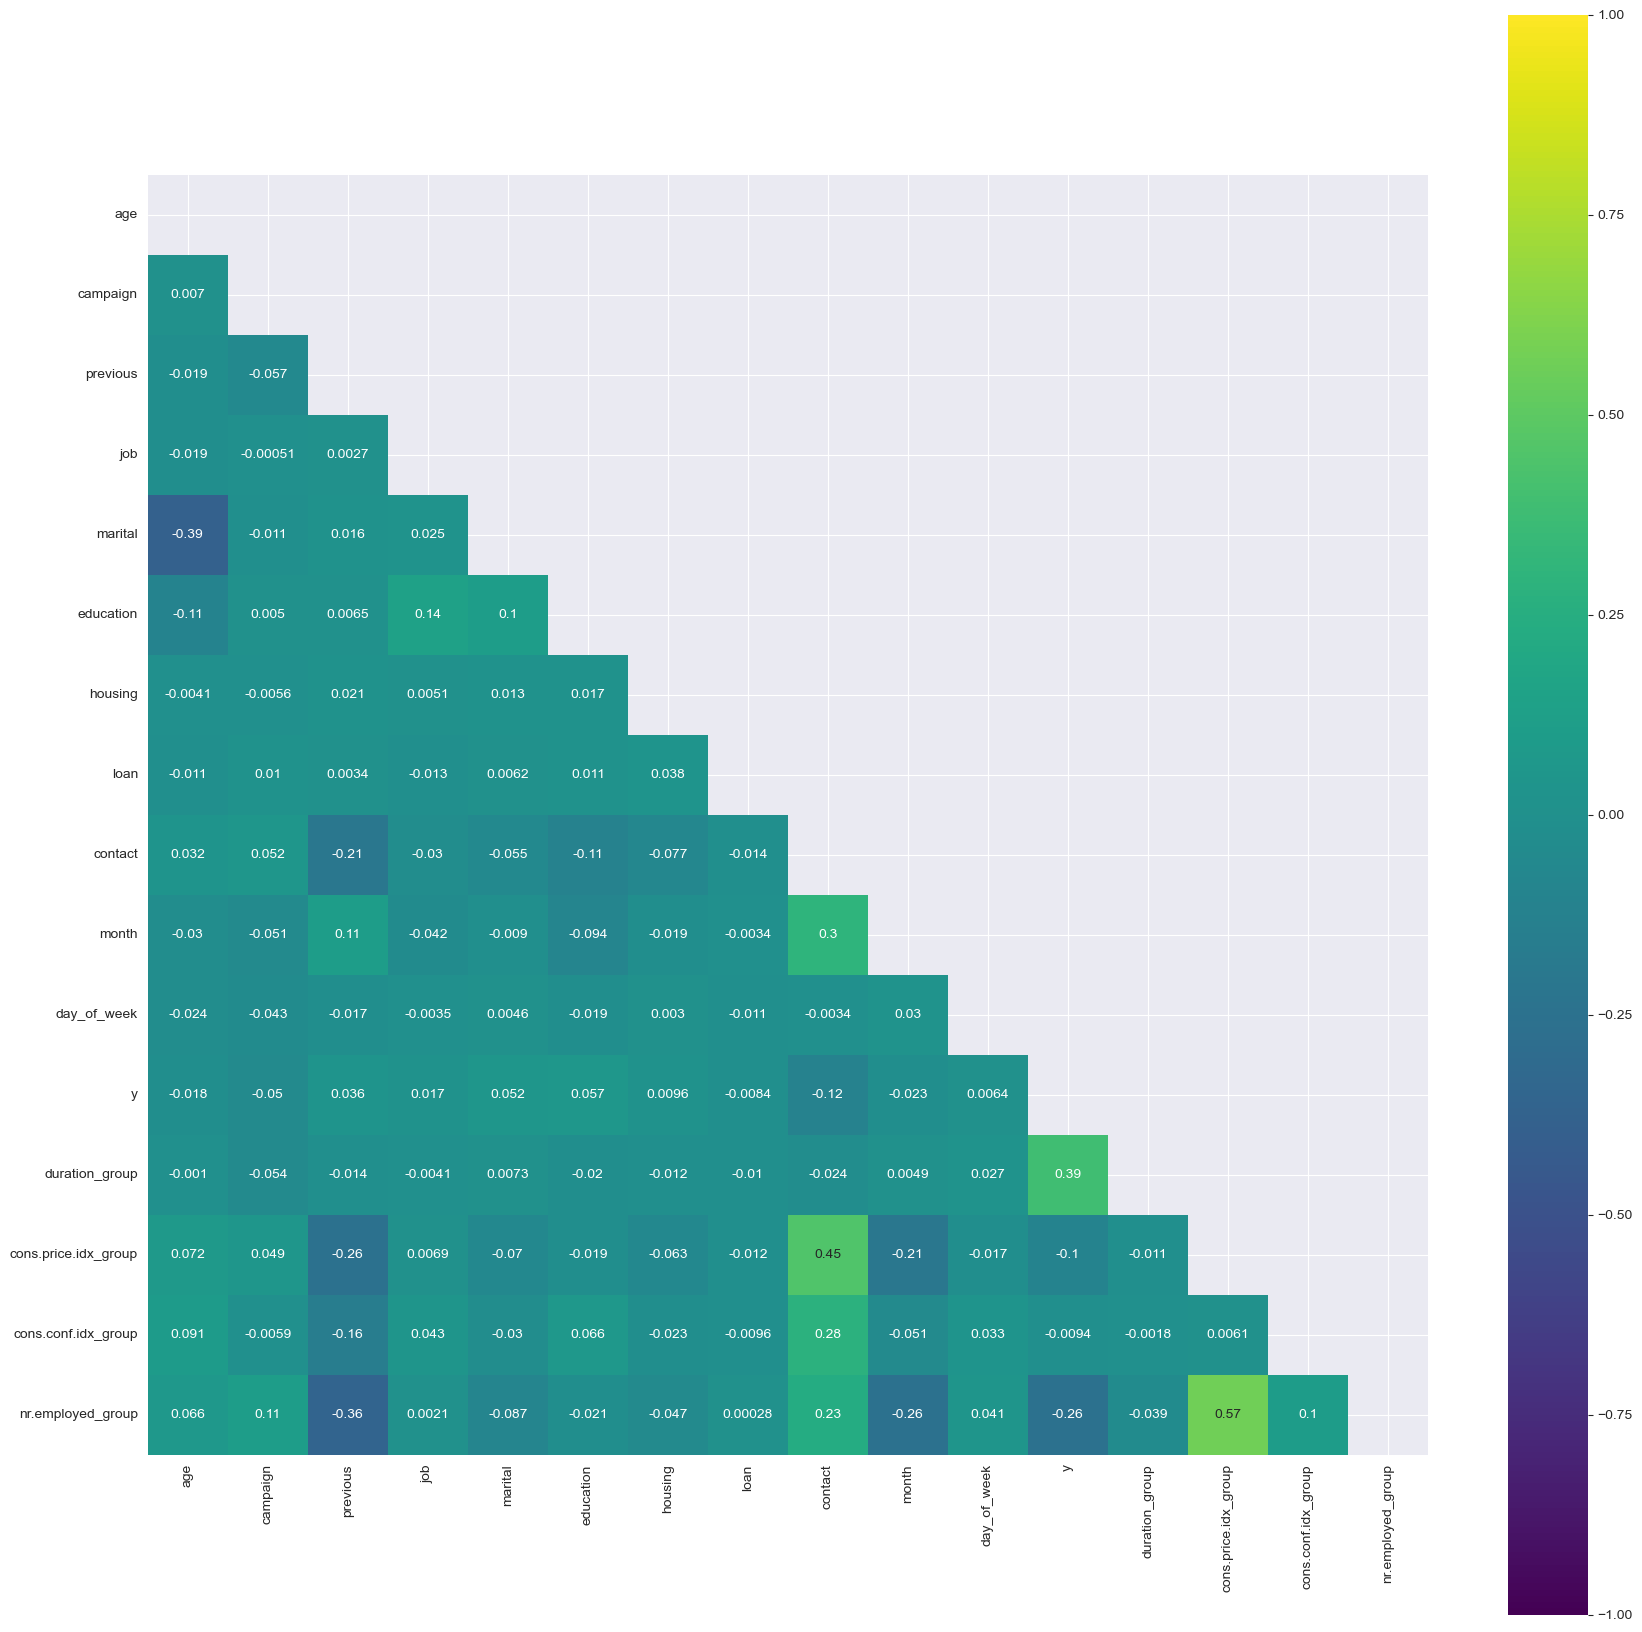

In [353]:
fig= plt.figure(figsize=(16,16))
corr = dataset_selected.corr()
mask = np.triu(dataset_selected.corr())

axes = fig.add_axes([0, 0, 1, 1])
sns.heatmap(corr, annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='viridis',
            linecolor='white', cbar_kws= {'orientation': 'vertical'}, ax=axes)

In [354]:
print(f"Samples in original clean dataset:\t{dataset_clean.shape[0]}, Features:\t{dataset_clean.shape[1]}")
print(f"Samples without selection:\t\t\t{dataset_no_selection.shape[0]}, Features:\t{dataset_no_selection.shape[1]}")
print(f"Samples with selection:\t\t\t\t{dataset_selected.shape[0]}, Features:\t{dataset_selected.shape[1]}")

Samples in original clean dataset:	37311, Features:	21
Samples without selection:			37311, Features:	25
Samples with selection:				37311, Features:	16


### Feature Sampling:

In [355]:
X = dataset_selected.drop(['y'], axis=1).copy()
y = dataset_selected['y'].copy()

In [356]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
oversampling = RandomOverSampler()
X_oversampled, y_oversampled = oversampling.fit_resample(X, y)

# Before feature sampling
counter_before = Counter(y)
# After feature sampling
counter_after = Counter(y_oversampled)

print(f"Before oversampling:{counter_before}")
print(f"After oversampling:{counter_after}")
print(f"Feature sampling percentage: %{((y_oversampled.shape[0] - y.shape[0])/y.shape[0])*100:.2f}")

Before oversampling:Counter({0: 34343, 1: 2968})
After oversampling:Counter({0: 34343, 1: 34343})
Feature sampling percentage: %84.09


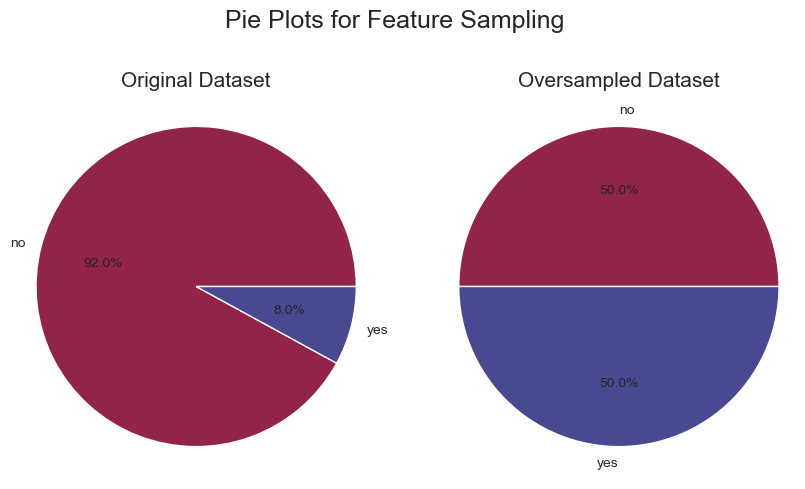

In [357]:
# Original dataset
counts_original = dataset_selected['y'].value_counts()
labels_original = ['no' if x == 0 else 'yes' for x in counts_original.index]

# Oversampled dataset
counts_oversampled = y_oversampled.value_counts()
labels_oversampled = ['no' if x == 0 else 'yes' for x in counts_oversampled.index]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot for original dataset
axs[0].pie(counts_original, labels=labels_original, autopct='%1.1f%%', startangle=0, colors=sns.color_palette("gist_stern"))
axs[0].set_title("Original Dataset", fontsize=15)
axs[0].axis('equal')  # Make the pie chart circular

# Plot for oversampled dataset
axs[1].pie(counts_oversampled, labels=labels_oversampled, autopct='%1.1f%%', startangle=0, colors=sns.color_palette("gist_stern"))
axs[1].set_title("Oversampled Dataset", fontsize=15)
axs[1].axis('equal')  # Make the pie chart circular

plt.suptitle("Pie Plots for Feature Sampling", fontsize=18, y=1.05)
plt.show()

# ---------------------------------------------------------------------------------------------------------------------------------

### Feature Scaling

In [358]:
from sklearn.preprocessing import RobustScaler
scaler_robust = RobustScaler()  # Since we have outliers that we couldn't remove we use robust scaler to resist outliers
X_robust = scaler_robust.fit_transform(X_oversampled)
X_non_negative = X_robust - X_robust.min() + 1e-10

### Feature Selection:

In [359]:
# Prepare dataset for RFE (Recursive Feature Elimination)
def func_RFE_X_rfe(param_X,param_y):
    model = RandomForestClassifier()
    rfe = RFE(model, step = 4)
    fit = rfe.fit(param_X,param_y)
    selected_features = fit.support_
    X_rfe = param_X[:, selected_features]
    return X_rfe

In [360]:
# Prepare dataset for SelectKBest (score_func=chi2)
def func_SelectKBest_X_chi2(param_X,param_y):
    test = SelectKBest(score_func=chi2, k=23)
    fit = test.fit(param_X,param_y)
    X_chi2 = fit.transform(param_X)
    return X_chi2

In [361]:
# Prepare dataset for Ridge
def func_Ridge_X_ridge(param_X,param_y):
    ridge = Ridge(alpha=1.0)
    ridge.fit(param_X,param_y)
    best_alpha = ridge.alpha
    ridge_model = Ridge(alpha=best_alpha)
    ridge_model.fit(param_X,param_y)
    selector = SelectFromModel(ridge_model)
    X_ridge = selector.transform(param_X)
    return X_ridge

In [362]:
# Prepare dataset for MIC (mutual_info_classification)
def func_MIC_X_mic(param_X,param_y):
    mi_scores = MIC(param_X,param_y)
    mi_score_selected_index = np.where(mi_scores <0.2)[0]
    X_mic = param_X[:,mi_score_selected_index]
    return X_mic

In [363]:
def func_Lasso_X(param_X, param_y):
    lasso = LassoCV(cv=10)
    lasso.fit(param_X, param_y)
    best_alpha = lasso.alpha_

    selector = SelectFromModel(Lasso(alpha=best_alpha), threshold='median')
    X_lasso = selector.fit_transform(param_X, param_y)

    return X_lasso

In [364]:
def print_scores(accuracy_score, recall_score, precision_score, f1_score, model_name):
    print(f"accuracy_{model_name}:{accuracy_score:10.4f}\t"
          f"recall {model_name}:{recall_score:10.4f}\t"
          f"precision {model_name}:{precision_score:10.4f}\t"
          f"f1_score_{model_name}:{f1_score:10.4f}")

In [365]:
def predict_scores(model, x_test, y_test):
    y_predict       = model.predict(x_test)
    score_accuracy  = accuracy_score(y_test, y_predict)
    score_recall    = recall_score(y_test,y_predict)
    score_precision = precision_score(y_test,y_predict)
    f1_scr          = f1_score(y_test, y_predict)
    return score_accuracy,score_recall,score_precision, f1_scr

In [366]:
def func_Calculate_Model_Scores(param_x,param_y, X_chi2, X_rfe, X_ridge, X_mic, X_lasso):
    # Split the data into training and testing sets
    
    X_train, X_test, y_train, y_test                     = train_test_split(param_x,param_y, random_state=0, stratify=param_y)
    X_train_chi2, X_test_chi2, y_train_chi2, y_test_chi2 = train_test_split(X_chi2, param_y, random_state=0, stratify=param_y)
    X_train_RFE, X_test_RFE, y_train_RFE, y_test_RFE     = train_test_split(X_rfe, param_y, random_state=0, stratify=param_y)
    X_train_Ridge, X_test_Ridge, y_train_Ridge, y_test_Ridge = train_test_split(X_ridge, param_y, random_state=0, stratify=param_y)
    X_train_MIC, X_test_MIC, y_train_MIC, y_test_MIC     = train_test_split(X_mic, param_y, random_state=0, stratify=param_y)
    X_train_Lasso, X_test_Lasso, y_train_Lasso, y_test_Lasso = train_test_split(X_lasso, param_y, random_state=0, stratify=param_y)
    RFC = RandomForestClassifier()

    # Compare results with Random Forest Classifier
    model_default = RFC.fit(X_train,y_train)
    score_default, recall_score_default, precision_score_default, f1_score_default = predict_scores(model_default,X_test,y_test) 

    model_MIC = RFC.fit(X_train_MIC,y_train_MIC)
    score_MIC, recall_score_MIC, precision_score_MIC, f1_score_MIC = predict_scores(model_MIC,X_test_MIC,y_test_MIC)

    model_chi2 = RFC.fit(X_train_chi2,y_train_chi2)
    score_chi2, recall_score_chi2, precision_score_chi2, f1_score_chi2 = predict_scores(model_chi2,X_test_chi2,y_test_chi2)

    model_RFE = RFC.fit(X_train_RFE,y_train_RFE)
    score_rfe, recall_score_rfe, precision_score_rfe, f1_score_rfe = predict_scores(model_RFE,X_test_RFE,y_test_RFE)

    model_Ridge = RFC.fit(X_train_Ridge,y_train_Ridge)
    score_ridge, recall_score_ridge, precision_score_ridge, f1_score_ridge = predict_scores(model_Ridge,X_test_Ridge,y_test_Ridge)

    model_Lasso = RFC.fit(X_train_Lasso,y_train_Lasso)
    score_lasso, recall_score_lasso, precision_score_lasso, f1_score_lasso = predict_scores(model_Lasso,X_test_Lasso,y_test_Lasso)
    
    #---------------------------------------------------------------------------------
    model_names = ['Default','CHI2','RFE','Ridge','MIC','Lasso']
    scores = [score_default ,score_chi2 ,score_rfe ,score_ridge ,score_MIC ,score_lasso]
    recalls = [recall_score_default ,recall_score_chi2 ,recall_score_rfe ,recall_score_ridge ,recall_score_MIC ,recall_score_lasso]
    precisions = [precision_score_default,precision_score_chi2,precision_score_rfe,precision_score_ridge,precision_score_MIC,precision_score_lasso]
    f1_scores = [f1_score_default,f1_score_chi2,f1_score_rfe,f1_score_ridge,f1_score_MIC,f1_score_lasso]

    scores_df = pd.DataFrame({
        "Model": model_names,
        "Score": scores,
        "Recall": recalls,
        "Precision": precisions,
        "F1 Score": f1_scores
    })
    
    return  scores_df

In [367]:
print("Scores for robust scaler:")
x_chi2 = func_SelectKBest_X_chi2(X_non_negative,y_oversampled)
x_rfe = func_RFE_X_rfe(X_non_negative,y_oversampled)
x_ridge = func_Ridge_X_ridge(X_non_negative,y_oversampled)
x_mic = func_MIC_X_mic(X_non_negative,y_oversampled)
x_lasso = func_Lasso_X(X_non_negative,y_oversampled)

df_featureSelection  = func_Calculate_Model_Scores(X_non_negative, y_oversampled, x_chi2, x_rfe, x_ridge, x_mic, x_lasso)
df_featureSelection

Scores for robust scaler:


,Model,Score,Recall,Precision,F1 Score
0,Default,0.974493,1.000000,0.951463,0.975128
1,CHI2,0.974610,1.000000,0.951674,0.975239
2,RFE,0.971290,1.000000,0.945699,0.972092
3,Ridge,0.846960,0.906476,0.810054,0.855557
4,MIC,0.974726,1.000000,0.951885,0.975349
5,Lasso,0.974610,1.000000,0.951674,0.975239


## Implementing Elbow 

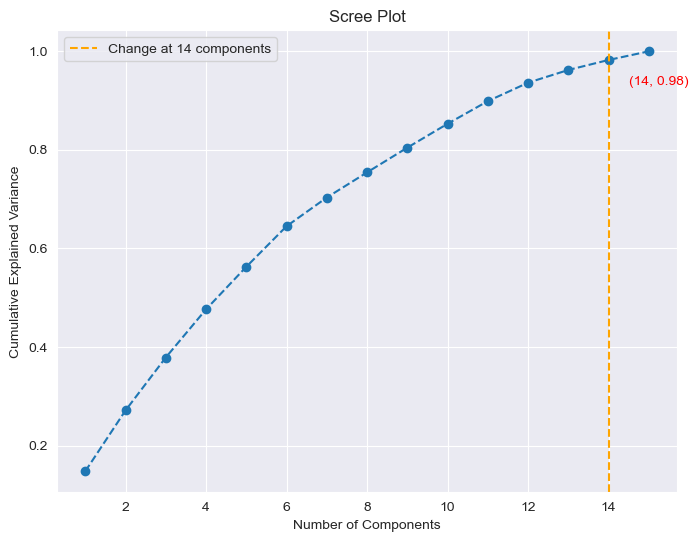

In [368]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA()
pca.fit(x_chi2)

explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')

# Calculate the rate of change in explained variance
diff = np.diff(cumulative_var)
change_point = np.where(diff == np.min(diff))[0][0] + 1

plt.axvline(x=change_point, color='orange', linestyle='--', label=f'Change at {change_point} components')
plt.text(change_point + 0.5, cumulative_var[change_point - 1] - 0.05, f'({change_point}, {cumulative_var[change_point - 1]:.2f})', color='red')

plt.legend()
plt.grid(True)
plt.show()

In [369]:
from sklearn.decomposition import PCA

pca = PCA(n_components=change_point) 
X_pca = pca.fit_transform(x_chi2)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y_oversampled, test_size=0.2, random_state=42)

model_rfc_pca = RandomForestClassifier()
model_rfc_pca.fit(X_train, y_train)

# Make predictions
y_pred = model_rfc_pca.predict(X_test)

score_default, recall_score_default, precision_score_default, f1_score_default = predict_scores(model_rfc_pca,X_test,y_test)

print("Scores for PCA with RandomForest:")
print("Accuracy: {:.4f}".format(score_default))
print("Recall: {:.4f}".format(recall_score_default))
print("Precision: {:.4f}".format(precision_score_default))
print("F1 Score: {:.4f}".format(f1_score_default))

Scores for PCA with RandomForest:
Accuracy: 0.9801
Recall: 1.0000
Precision: 0.9617
F1 Score: 0.9805


# ---------------------------------------------------------------------------------------------------------------------------------

# Splitting the dataset into the Training set and Test set

In [370]:
X_train, X_test, y_train, y_test   = train_test_split(X_pca,y_oversampled, random_state=42)

# Feature Scaling

In [371]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# ML Algorithms Implementation:

In [372]:
def plot_confusion_matrices(X_test, y_test, models, model_names):
    num_models = len(models)

    # Create subplots based on the number of models
    fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 5))

    for i, (model, model_name) in enumerate(zip(models, model_names)):
        # Generate confusion matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        # Create a custom colormap for better readability
        cmap = sns.diverging_palette(250, 10, as_cmap=True)

        # Create a heatmap with customized colors and annotations
        ax = axes[i] if num_models > 1 else axes
        sns.heatmap(cm, annot=True, cmap=cmap, fmt='g', cbar=False, ax=ax)

        # Set labels, title, and layout
        ax.set_title(f'Confusion Matrix of {model_name}', fontsize=16)
        ax.set_xlabel('Predicted', fontsize=8)
        ax.set_ylabel('Actual', fontsize=8)
        ax.set_xticks([0.5, 1.5])
        ax.set_xticklabels(['Negative', 'Positive'])
        ax.set_yticks([0.5, 1.5])
        ax.set_yticklabels(['Negative', 'Positive'])
        ax.tick_params(axis='both', which='both', length=0)  # Remove ticks

    plt.tight_layout()
    plt.show()

In [373]:
from sklearn.metrics import roc_curve, roc_auc_score

def draw_AUC_graph(train_X, test_X, train_y, test_y, models, model_names):
    num_models = len(models)

    # Create subplots with the number of rows determined by the number of models
    fig, axes = plt.subplots(1, ncols=num_models, figsize=(6*num_models,5))

    for i in range(num_models):
        model = models[i]
        model_name = model_names[i]

        # Get predicted probabilities for the positive class for both train and test sets
        y_train_probs = model.predict_proba(train_X)[:, 1]
        y_test_probs = model.predict_proba(test_X)[:, 1]

        # Compute ROC curve and ROC AUC for both train and test sets
        fpr_train, tpr_train, _ = roc_curve(train_y, y_train_probs)
        fpr_test, tpr_test, _ = roc_curve(test_y, y_test_probs)

        roc_auc_train = roc_auc_score(train_y, y_train_probs)
        roc_auc_test = roc_auc_score(test_y, y_test_probs)

        # Plot ROC curves for both train and test sets, display AUC values as labels
        if num_models > 1:
            ax = axes[i]
        else:
            ax = axes

        ax.plot(fpr_train, tpr_train, label=f'Train ROC Curve (AUC = {roc_auc_train:.2f})')
        ax.plot(fpr_test, tpr_test, label=f'Test ROC Curve (AUC = {roc_auc_test:.2f})')
        ax.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
        ax.set_xlabel('False Positive Rate (FPR)')
        ax.set_ylabel('True Positive Rate (TPR)')
        ax.set_title(f'Receiver Operating Characteristic (ROC) Curve for {model_name}')
        ax.legend()

        print(f"{model_name} - Train AUC: {roc_auc_train:.4f}")
        print(f"{model_name} - Test AUC: {roc_auc_test:.4f}")

    plt.tight_layout()
    plt.show()

In [375]:
def bias_variance(model, X_train, y_train):
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=3)

    # Calculate the mean for training and test scores
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    bias = 1 - train_mean
    variance = test_mean - train_mean

    # Plot Bias-Variance Tradeoff
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(train_sizes, bias, 'o-', color="blue", label="Bias")
    ax.plot(train_sizes, variance, 'o-', color="orange", label="Variance")
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Error")
    ax.set_title("Bias-Variance Tradeoff for the dataset")
    ax.legend(loc="best")
    ax.grid()
    ax.set_ylim(bottom=-1, top=1)
    plt.show()

In [376]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def visualize_fitting_scores(models, model_names, X_train, y_train, X_test, y_test):
    num_models = len(models)

    fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(5 * num_models, 6))

    for i in range(num_models):
        model = models[i]
        model_name = model_names[i]

        train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=3)

        # Calculate the mean for training and test scores
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)
        
        # Plot Learning Curve
        axes[i].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="b")
        axes[i].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="r")
        axes[i].plot(train_sizes, train_mean, 'o-', color="blue", label="Training score")
        axes[i].plot(train_sizes, test_mean, 'o-', color="red", label="Cross-validation score")

        # Calculate test score separately
        test_sizes = np.array([(j + 1) * len(X_train) // 10 for j in range(10)])
        test_score = [model.score(X_test[:size], y_test[:size]) for size in test_sizes]
        axes[i].plot(test_sizes, test_score, 'o-', color="orange", label="Test score")

        axes[i].set_xlabel("Training examples")
        axes[i].set_ylabel("Score")
        axes[i].set_title(f"Learning Curve with Training, Cross-validation, and Test Scores for {model_name}")
        axes[i].legend(loc="best")
        axes[i].grid()

    plt.tight_layout()
    plt.show()

In [377]:
def ml_algorithms(X_train,y_train):

    # Initialize individual classifiers
    dtc = DecisionTreeClassifier()
    knn = KNeighborsClassifier()
    logistic = LogisticRegression(max_iter=1000)
    rfc = RandomForestClassifier()
    gb = GradientBoostingClassifier()

    # Fit individual classifiers
    dtc.fit(X_train, y_train)
    knn.fit(X_train, y_train)
    logistic.fit(X_train, y_train)
    rfc.fit(X_train, y_train)
    gb.fit(X_train, y_train)
    
    return dtc, knn, logistic, rfc, gb

In [378]:
!pip install xgboost
!pip install optuna

In [379]:
def ensemble_models(X_train,y_train,estimators):
    
    xgboost = xgb.XGBClassifier()
    voting = VotingClassifier(estimators=estimators, voting='soft')
    stacking = StackingClassifier(estimators=estimators)

    xgboost.fit(X_train,y_train)
    voting.fit(X_train,y_train)
    stacking.fit(X_train,y_train)
    
    return  xgboost, voting, stacking

# Training the Classification models on the Training set

## ML Models

In [380]:
model_dtc, model_knn, model_lr, model_rfc, model_gb= ml_algorithms(X_train=X_train,y_train=y_train)

## Ensemble Models

In [381]:
estimators = [('dtc',model_dtc),('knn',model_knn),('logistic',model_lr),('rfc',model_rfc),('gb', model_gb)]
model_xgb, model_voting, model_stacking = ensemble_models(X_train=X_train,y_train=y_train,estimators=estimators)

# Hyper tuning of ML and ensemble models

## RFC

In [382]:
param_grid = {
    'n_estimators': [50, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1,5],
    'random_state': [0,42]
}

# Create GridSearchCV
grid_search = GridSearchCV(estimator=model_rfc, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, error_score='raise')

# Perform grid search on training data
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
{'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 0}


In [383]:
best_model_rfc = RandomForestClassifier(**best_params)
best_model_rfc.fit(X_train, y_train)

RandomForestClassifier(max_features=1, random_state=0)

## XGB

In [384]:
# taking from https://optuna.readthedocs.io/en/stable/
def objective(trial):
    param_grid = {
        'objective': 'binary:logistic',
        'eval_metric': 'error',
        'booster': 'gbtree',
        'verbosity': 0,
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    xgb_model = xgb.XGBClassifier(**param_grid)
    xgb_model.fit(X_train, y_train)

    predictions = xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return 1.0 - accuracy 

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')  # Minimize the error (1 - accuracy)
study.optimize(objective, n_trials=100)
print(best_params)

[I 2024-01-23 14:48:14,867] A new study created in memory with name: no-name-ce9dc8ff-2619-4120-8e9d-695f36e5e79e
[I 2024-01-23 14:48:15,731] Trial 0 finished with value: 0.07011413929652921 and parameters: {'n_estimators': 564, 'max_depth': 5, 'learning_rate': 0.047232008882187315, 'subsample': 0.8773537305038168, 'colsample_bytree': 0.7828008775251489, 'gamma': 0.8883889399384651, 'min_child_weight': 7}. Best is trial 0 with value: 0.07011413929652921.
[I 2024-01-23 14:48:16,501] Trial 1 finished with value: 0.047111576985790826 and parameters: {'n_estimators': 738, 'max_depth': 4, 'learning_rate': 0.18583155638293505, 'subsample': 0.9864939932239496, 'colsample_bytree': 0.5113885586911832, 'gamma': 0.5506572268922953, 'min_child_weight': 3}. Best is trial 1 with value: 0.047111576985790826.
[I 2024-01-23 14:48:17,434] Trial 2 finished with value: 0.0369788027020731 and parameters: {'n_estimators': 241, 'max_depth': 9, 'learning_rate': 0.06558563888426838, 'subsample': 0.873153357171

{'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 0}


In [385]:
best_model_xgb = xgb.XGBClassifier(**best_params)
best_model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_features=1,
              max_leaves=None, min_child_weight=None, min_samples_leaf=1,
              min_samples_split=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, ...)

### Printing the accuracy,recall,precision,f1 scores for models:

In [386]:
models = [model_dtc, model_knn, model_lr, model_rfc, model_gb, model_xgb, model_voting, model_stacking, best_model_rfc, best_model_xgb]
model_names = ["Decision Tree","KNN","Logistic_regression","Random Forest", "GB", "XGB", "Voting", "Stacking", "Optimized Random Forest", "Optimized XGB"]

In [387]:
# Initialize empty lists to store scores
accuracy_scores, recall_scores, precision_scores, f1_scores = [], [], [], []

# Calculate and store scores for each model
for model in models:
    accuracy, recall, precision, f1 = predict_scores(model, X_test, y_test)
    accuracy_scores.append(accuracy)
    recall_scores.append(recall)
    precision_scores.append(precision)
    f1_scores.append(f1)

# Create a DataFrame using the scores and model names
scores_df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracy_scores,
    "Recall": recall_scores,
    "Precision": precision_scores,
    "F1 Score": f1_scores
})

In [388]:
scores_df

,Model,Accuracy,Recall,Precision,F1 Score
0,Decision Tree,0.970359,1.000000,0.944244,0.971322
1,KNN,0.936641,0.998376,0.889050,0.940546
2,Logistic_regression,0.845155,0.867749,0.831203,0.849083
3,Random Forest,0.980783,1.000000,0.963128,0.981218
4,GB,0.877941,0.921578,0.848355,0.883452
5,XGB,0.952830,0.996404,0.916845,0.954970
6,Voting,0.958828,1.000000,0.924199,0.960606
7,Stacking,0.997729,1.000000,0.995496,0.997743
8,Optimized Random Forest,0.987654,1.000000,0.975996,0.987852
9,Optimized XGB,0.952830,0.996404,0.916845,0.954970


In [389]:
selected_models = [model_stacking, best_model_rfc, best_model_xgb]
selected_model_names = ["Stacking", "Optimized Random Forest", "Optimized XGB"]

## Visualizing the Confusion Matrix

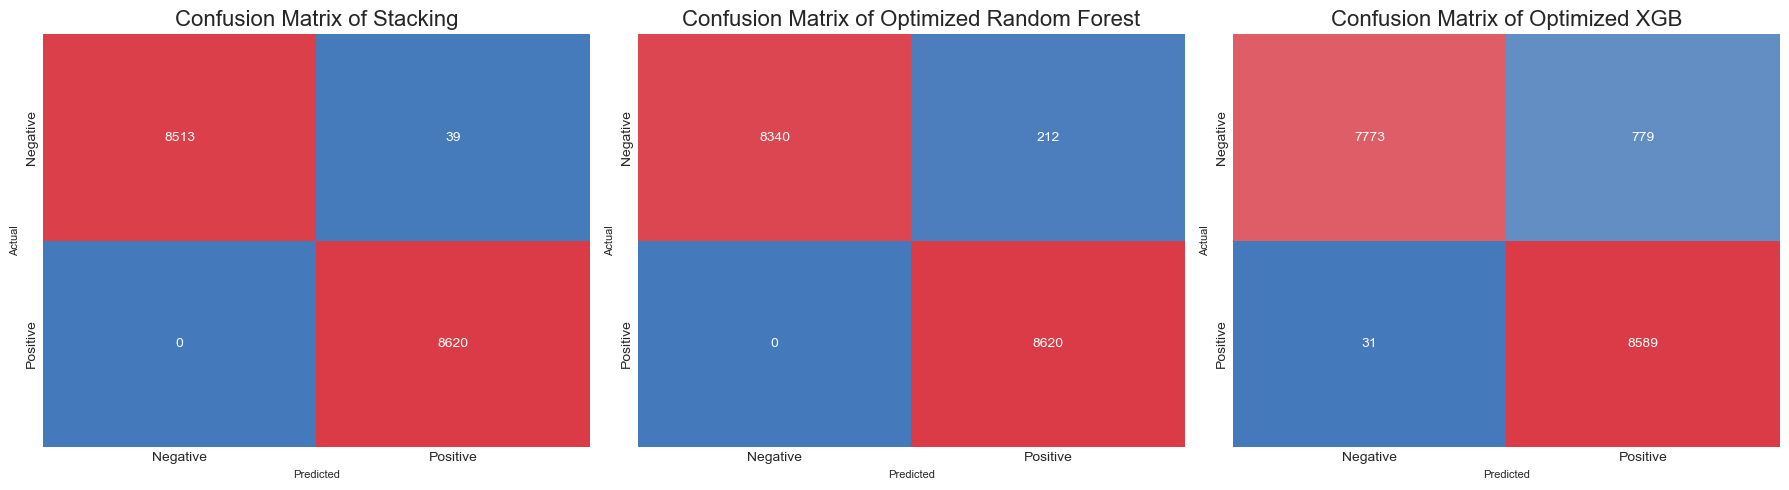

In [390]:
plot_confusion_matrices(X_test=X_test, y_test=y_test, models=selected_models, model_names=selected_model_names)

## Visualizing the ROC curve with AUC values

Stacking - Train AUC: 0.9999
Stacking - Test AUC: 0.9998
Optimized Random Forest - Train AUC: 1.0000
Optimized Random Forest - Test AUC: 0.9999
Optimized XGB - Train AUC: 0.9979
Optimized XGB - Test AUC: 0.9852


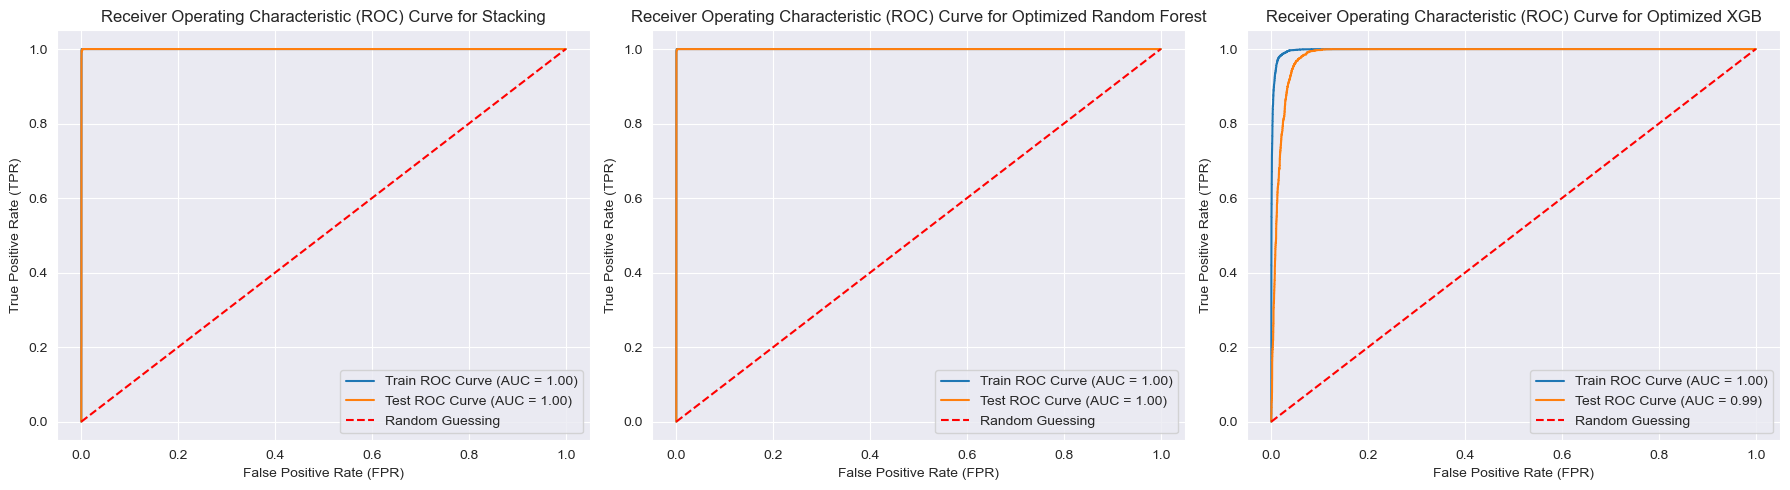

In [391]:
draw_AUC_graph(X_train, X_test, y_train, y_test, models=selected_models, model_names=selected_model_names)

## Visualizing the bias,variance tradeoff and train,test,cross-validation scores

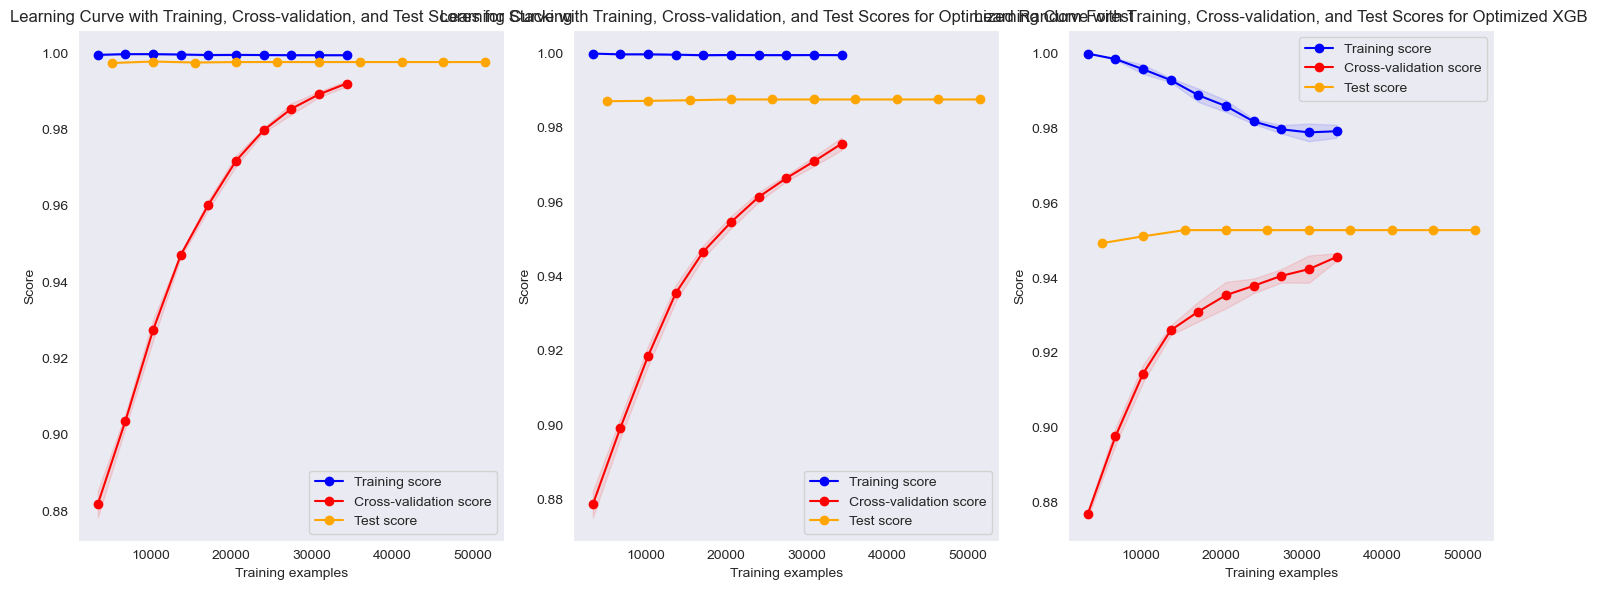

In [392]:
visualize_fitting_scores(models=selected_models, model_names=selected_model_names, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

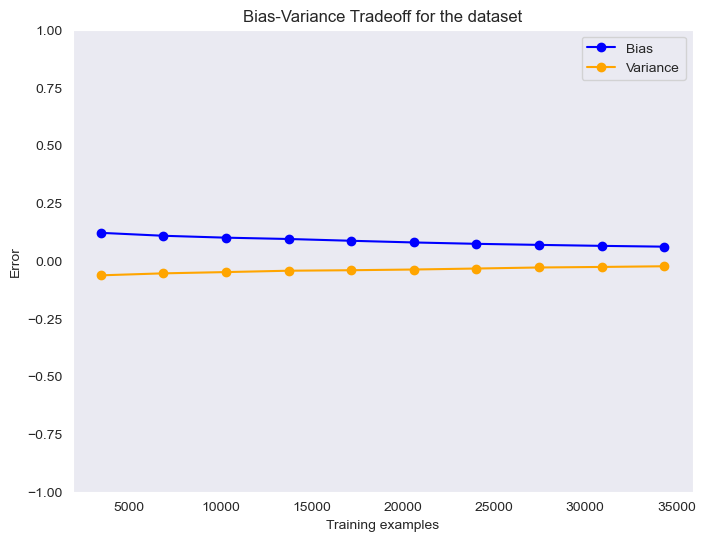

In [395]:
bias_variance(model_knn,X_train,y_train)